In [15]:
# ============================================================
# CELL 1: Dataset Configuration with Volume Pre-Sampling
# ============================================================
import os
from glob import glob
import numpy as np

print("="*70)
print("BRAIN TUMOR SEGMENTATION USING ACTIVE LEARNING")
print("="*70)

BRATS_PATHS = {
    'training': "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData",
    'validation': "/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"
}

DATASET_CONFIG = {
    'modality': 't1ce',
    'initial_volume_ratio': 0.05,  # Start with 10% of volumes
    'total_available_volumes': 369,
    'use_validation': False,
}

MODALITY_SUFFIX = {
    't1': '_t1.nii',
    't1ce': '_t1ce.nii',
    't2': '_t2.nii',
    'flair': '_flair.nii',
    'seg': '_seg.nii'
}

def get_all_brats_file_pairs():
    """Get all available file pairs"""
    file_pairs = []
    
    if os.path.exists(BRATS_PATHS['training']):
        patient_dirs = sorted(glob(os.path.join(BRATS_PATHS['training'], "BraTS20_Training_*")))
        
        for patient_dir in patient_dirs:
            patient_id = os.path.basename(patient_dir)
            img_file = os.path.join(patient_dir, f"{patient_id}{MODALITY_SUFFIX[DATASET_CONFIG['modality']]}")
            seg_file = os.path.join(patient_dir, f"{patient_id}{MODALITY_SUFFIX['seg']}")
            
            if os.path.exists(img_file) and os.path.exists(seg_file):
                file_pairs.append((img_file, seg_file))
    
    return file_pairs

# Get all available file pairs
all_file_pairs = get_all_brats_file_pairs()

print(f"\nDataset Information:")
print(f"  Modality: {DATASET_CONFIG['modality'].upper()}")
print(f"  Total volumes available: {len(all_file_pairs)}")
print(f"  Initial volume sampling: {DATASET_CONFIG['initial_volume_ratio']*100:.0f}%")

if len(all_file_pairs) > 0:
    print(f"\nExample file pair:")
    print(f"  Image: {os.path.basename(all_file_pairs[0][0])}")
    print(f"  Mask:  {os.path.basename(all_file_pairs[0][1])}")

print("\nDataset paths configured successfully!")
print("="*70)


BRAIN TUMOR SEGMENTATION USING ACTIVE LEARNING

Dataset Information:
  Modality: T1CE
  Total volumes available: 368
  Initial volume sampling: 5%

Example file pair:
  Image: BraTS20_Training_001_t1ce.nii
  Mask:  BraTS20_Training_001_seg.nii

Dataset paths configured successfully!


In [16]:
# ============================================================
# CELL 2: CORRECTED Configuration with Proper Tversky Parameters
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.cuda.amp import autocast, GradScaler
import nibabel as nib
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import zoom
import warnings
import gc
from tqdm import tqdm

warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# CORRECTED CONFIGURATION
CONFIG = {
    # Patch extraction
    'patch_size': 128,
    'stride': 32,  
    
    # Active learning
    'initial_samples_ratio': 0.05,  
    'query_samples_per_iter': 30,   
    'al_iterations': 30,             
    
    # Training parameters
    'batch_size': 16,                
    'epochs_per_iteration': 20,      
    'learning_rate': 2e-4,           
    'min_lr': 1e-6,                  
    'warmup_epochs': 3,              
    'weight_decay': 0.003,           
    
    # Performance thresholds
    'dice_threshold': 0.90,
    'max_patches_per_volume': 400,   
    
    # Optimization
    'use_mixed_precision': True,
    'gradient_clip': 1.0,
    'label_smoothing': 0.1,          
    
    # Model architecture
    'prototype_dim': 256,
    'base_channels': 48,             
    'dropout': 0.2,                  
    
    # Loss weights
    'focal_tversky_weight': 0.35,    
    'lovasz_weight': 0.30,           
    'ce_weight': 0.20,               
    'boundary_weight': 0.10,         
    'aux_weight': 0.05,              
    
    # CORRECTED Tversky parameters
    # NOTE: These are used in Cell 5, not here
    # alpha = FN weight (0.7 = heavily penalize missed tumors)
    # beta = FP weight (0.3 = lightly penalize extra pixels)
    'tversky_alpha': 0.7,  # CORRECTED: FN weight HIGH
    'tversky_beta': 0.3,   # CORRECTED: FP weight LOW
    'tversky_gamma': 0.75,
    
    # CORRECTED prediction threshold
    'prediction_threshold': 0.4,  # NEW: Lower threshold for fuzzy boundaries
    
    # Class balancing - CORRECTED to 70/30
    'tumor_nontumor_ratio': 0.7,  # CORRECTED: 70% tumor, 30% background
    'use_augmentation': False,       
    
    # Query diversity
    'diversity_clusters': 5,         
    'uncertainty_weight': 0.35,
    'diversity_weight': 0.35,
    'representativeness_weight': 0.30,
}

print("\n" + "="*70)
print("CORRECTED CONFIGURATION")
print("="*70)
print("\nKEY CORRECTIONS APPLIED:")
print("\n1. TVERSKY PARAMETERS (used in Cell 5):")
print(f"   alpha (FN weight) = {CONFIG['tversky_alpha']} (0.7)")
print(f"   beta (FP weight) = {CONFIG['tversky_beta']} (0.3)")
print(f"   Interpretation: Heavily penalize MISSED tumors (FN)")
print(f"                  Lightly penalize EXTRA pixels (FP)")
print(f"   Result: Model over-segments, refines with post-processing")

print("\n2. PREDICTION THRESHOLD:")
print(f"   threshold = {CONFIG['prediction_threshold']} (was 0.5)")
print(f"   Why? Tumors have fuzzy boundaries")
print(f"        Lower threshold catches edge pixels")
print(f"        Improves sensitivity for small tumors")

print("\n3. BATCH SAMPLING RATIO:")
print(f"   tumor_ratio = {CONFIG['tumor_nontumor_ratio']} (70% tumor)")
print(f"   Why? Tumor is only 2-5% of volume")
print(f"        70/30 split ensures enough tumor examples")
print(f"        Prevents model from learning only background")

print("\nEXPECTED IMPROVEMENTS:")
print("  - Higher sensitivity (catch more tumor pixels)")
print("  - Better boundary detection")
print("  - More balanced learning")
print("="*70)

def print_gpu_memory():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        print(f"GPU Memory: Allocated={allocated:.2f}GB, Reserved={reserved:.2f}GB")

print("\nInitial Memory:")
print_gpu_memory()

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("\nConfiguration loaded successfully!")

Using device: cuda
GPU: Tesla T4

CORRECTED CONFIGURATION

KEY CORRECTIONS APPLIED:

1. TVERSKY PARAMETERS (used in Cell 5):
   alpha (FN weight) = 0.7 (0.7)
   beta (FP weight) = 0.3 (0.3)
   Interpretation: Heavily penalize MISSED tumors (FN)
                  Lightly penalize EXTRA pixels (FP)
   Result: Model over-segments, refines with post-processing

2. PREDICTION THRESHOLD:
   threshold = 0.4 (was 0.5)
   Why? Tumors have fuzzy boundaries
        Lower threshold catches edge pixels
        Improves sensitivity for small tumors

3. BATCH SAMPLING RATIO:
   tumor_ratio = 0.7 (70% tumor)
   Why? Tumor is only 2-5% of volume
        70/30 split ensures enough tumor examples
        Prevents model from learning only background

EXPECTED IMPROVEMENTS:
  - Higher sensitivity (catch more tumor pixels)
  - Better boundary detection
  - More balanced learning

Initial Memory:
GPU Memory: Allocated=0.23GB, Reserved=0.30GB

Configuration loaded successfully!


In [17]:
# ============================================================
# CELL 3: Optimized Patch Extractor with Balanced Sampling
# ============================================================

class OptimizedPatchExtractor:
    """
    Optimized patch extractor with:
    - Balanced tumor/non-tumor sampling
    - No augmentation (as requested)
    - Higher overlap for better coverage
    """
    def __init__(self, patch_size=128, stride=32):
        self.patch_size = patch_size
        self.stride = stride
        print(f"Patch Extractor initialized:")
        print(f"  Patch size: {patch_size}x{patch_size}")
        print(f"  Stride: {stride} (overlap: {patch_size-stride}px / {(1-stride/patch_size)*100:.0f}%)")
        
    def extract_patches_with_context(self, volume, mask=None):
        """Extract patches with importance scoring"""
        patches = []
        patch_masks = []
        patch_coords = []
        importance_scores = []
        
        d, h, w = volume.shape
        
        for slice_idx in range(d):
            slice_img = volume[slice_idx, :, :]
            slice_mask = mask[slice_idx, :, :] if mask is not None else None
            
            # Skip empty slices
            if np.sum(np.abs(slice_img)) < 1e-6:
                continue
            
            for i in range(0, h - self.patch_size + 1, self.stride):
                for j in range(0, w - self.patch_size + 1, self.stride):
                    patch = slice_img[i:i+self.patch_size, j:j+self.patch_size]
                    
                    # Calculate importance score
                    patch_std = np.std(patch)
                    patch_mean = np.mean(np.abs(patch))
                    
                    # Skip very empty patches
                    if patch_mean < 1e-6 and patch_std < 0.01:
                        continue
                    
                    # Importance: variance × intensity
                    importance = patch_std * (patch_mean + 1e-6)
                    
                    patches.append(patch)
                    patch_coords.append((slice_idx, i, j))
                    importance_scores.append(importance)
                    
                    if slice_mask is not None:
                        mask_patch = slice_mask[i:i+self.patch_size, j:j+self.patch_size]
                        patch_masks.append(mask_patch)
        
        if len(patches) == 0:
            return np.array([]), np.array([]), np.array([]), np.array([])
        
        patches = np.array(patches)
        patch_coords = np.array(patch_coords)
        importance_scores = np.array(importance_scores)
        
        if mask is not None:
            patch_masks = np.array(patch_masks)
            return patches, patch_masks, patch_coords, importance_scores
        
        return patches, patch_coords, importance_scores
    
    def balance_patches(self, patches, masks, importance, max_patches, 
                       tumor_nontumor_ratio=1.5):
        """
        Balance tumor and non-tumor patches without augmentation
        
        Args:
            tumor_nontumor_ratio: ratio of non-tumor to tumor patches
        """
        # Identify tumor vs non-tumor patches
        has_tumor = np.array([np.any(m > 0) for m in masks])
        tumor_indices = np.where(has_tumor)[0]
        nontumor_indices = np.where(~has_tumor)[0]
        
        # Calculate balanced quantities
        n_tumor = len(tumor_indices)
        n_nontumor = len(nontumor_indices)
        
        if n_tumor == 0:
            # No tumor patches, just select top by importance
            selected_idx = np.argsort(importance)[-max_patches:]
        else:
            # Calculate target quantities
            target_tumor = min(n_tumor, int(max_patches / (1 + tumor_nontumor_ratio)))
            target_nontumor = min(n_nontumor, int(target_tumor * tumor_nontumor_ratio))
            
            # Adjust if we don't have enough
            total = target_tumor + target_nontumor
            if total > max_patches:
                scale = max_patches / total
                target_tumor = int(target_tumor * scale)
                target_nontumor = max_patches - target_tumor
            
            # Select tumor patches (all if possible, or by importance)
            if target_tumor >= n_tumor:
                selected_tumor = tumor_indices
            else:
                tumor_importance = importance[tumor_indices]
                top_tumor_idx = np.argsort(tumor_importance)[-target_tumor:]
                selected_tumor = tumor_indices[top_tumor_idx]
            
            # Select non-tumor patches by importance
            if target_nontumor >= n_nontumor:
                selected_nontumor = nontumor_indices
            else:
                nontumor_importance = importance[nontumor_indices]
                top_nontumor_idx = np.argsort(nontumor_importance)[-target_nontumor:]
                selected_nontumor = nontumor_indices[top_nontumor_idx]
            
            # Combine
            selected_idx = np.concatenate([selected_tumor, selected_nontumor])
        
        return patches[selected_idx], masks[selected_idx], importance[selected_idx]
    
    def normalize_patches(self, patches):
        """Robust patch normalization"""
        if len(patches) == 0:
            return patches
            
        normalized = []
        for patch in patches:
            # Percentile-based normalization
            p_min, p_max = np.percentile(patch, [1, 99])
            
            if p_max > p_min:
                patch_clipped = np.clip(patch, p_min, p_max)
                normalized_patch = (patch_clipped - p_min) / (p_max - p_min)
            else:
                normalized_patch = np.ones_like(patch) * 0.5
            
            normalized_patch = np.clip(normalized_patch, 0, 1)
            normalized.append(normalized_patch)
        
        return np.array(normalized)

# Initialize patch extractor
patch_extractor = OptimizedPatchExtractor(
    patch_size=CONFIG['patch_size'],
    stride=CONFIG['stride']
)

print("\nOptimized patch extractor ready!")
print(f"  Balanced sampling enabled (ratio 1:{CONFIG['tumor_nontumor_ratio']})")
print(f"  Augmentation: {'ENABLED' if CONFIG['use_augmentation'] else 'DISABLED'}")

Patch Extractor initialized:
  Patch size: 128x128
  Stride: 32 (overlap: 96px / 75%)

Optimized patch extractor ready!
  Balanced sampling enabled (ratio 1:0.7)
  Augmentation: DISABLED


In [18]:
# ============================================================
# CELL 4: Optimized Attention U-Net with Prototype Learning
# ============================================================

class AttentionBlock(nn.Module):
    """Attention mechanism for U-Net"""
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class ResidualBlock(nn.Module):
    """Residual block with batch normalization"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        residual = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = self.relu(out)
        return out

class AttentionUNetWithPrototypes(nn.Module):
    """
    Optimized Attention U-Net:
    - Lighter architecture (base_channels=48)
    - Less dropout (0.2 instead of 0.3)
    - Prototype learning for active learning
    """
    def __init__(self, in_channels=1, num_classes=2, base_channels=48):
        super().__init__()
        
        # Encoder
        self.enc1 = ResidualBlock(in_channels, base_channels)
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = ResidualBlock(base_channels, base_channels*2)
        self.pool2 = nn.MaxPool2d(2)
        
        self.enc3 = ResidualBlock(base_channels*2, base_channels*4)
        self.pool3 = nn.MaxPool2d(2)
        
        self.enc4 = ResidualBlock(base_channels*4, base_channels*8)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck with reduced dropout
        self.bottleneck = nn.Sequential(
            ResidualBlock(base_channels*8, base_channels*16),
            nn.Dropout2d(CONFIG['dropout'])
        )
        
        # Decoder with attention
        self.up4 = nn.ConvTranspose2d(base_channels*16, base_channels*8, 2, stride=2)
        self.att4 = AttentionBlock(base_channels*8, base_channels*8, base_channels*4)
        self.dec4 = ResidualBlock(base_channels*16, base_channels*8)
        
        self.up3 = nn.ConvTranspose2d(base_channels*8, base_channels*4, 2, stride=2)
        self.att3 = AttentionBlock(base_channels*4, base_channels*4, base_channels*2)
        self.dec3 = ResidualBlock(base_channels*8, base_channels*4)
        
        self.up2 = nn.ConvTranspose2d(base_channels*4, base_channels*2, 2, stride=2)
        self.att2 = AttentionBlock(base_channels*2, base_channels*2, base_channels)
        self.dec2 = ResidualBlock(base_channels*4, base_channels*2)
        
        self.up1 = nn.ConvTranspose2d(base_channels*2, base_channels, 2, stride=2)
        self.att1 = AttentionBlock(base_channels, base_channels, base_channels//2)
        self.dec1 = ResidualBlock(base_channels*2, base_channels)
        
        # Output with deep supervision
        self.output = nn.Conv2d(base_channels, num_classes, 1)
        self.output_aux = nn.Conv2d(base_channels*2, num_classes, 1)
        
        # Prototype projection head for active learning
        self.prototype_proj = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(base_channels*16, CONFIG['prototype_dim']),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout'])
        )
        
    def forward(self, x, return_features=False):
        # Encoder path
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)
        
        # Bottleneck
        b = self.bottleneck(p4)
        
        # Extract prototype features
        proto_features = self.prototype_proj(b)
        
        # Decoder path with attention
        d4 = self.up4(b)
        e4_att = self.att4(d4, e4)
        d4 = torch.cat([d4, e4_att], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.up3(d4)
        e3_att = self.att3(d3, e3)
        d3 = torch.cat([d3, e3_att], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        e2_att = self.att2(d2, e2)
        d2 = torch.cat([d2, e2_att], dim=1)
        d2 = self.dec2(d2)
        
        # Auxiliary output for deep supervision
        aux_out = F.interpolate(self.output_aux(d2), scale_factor=2, 
                               mode='bilinear', align_corners=False)
        
        d1 = self.up1(d2)
        e1_att = self.att1(d1, e1)
        d1 = torch.cat([d1, e1_att], dim=1)
        d1 = self.dec1(d1)
        
        out = self.output(d1)
        
        if return_features:
            return out, aux_out, proto_features
        return out, aux_out

# Initialize model
model = AttentionUNetWithPrototypes(
    in_channels=1, 
    num_classes=2, 
    base_channels=CONFIG['base_channels']
).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"\nAttention U-Net Model Initialized:")
print(f"  Total parameters: {n_params:,}")
print(f"  Model size: ~{n_params * 4 / 1024**2:.1f} MB")
print(f"  Base channels: {CONFIG['base_channels']}")
print(f"  Dropout: {CONFIG['dropout']}")
print(f"  Prototype dim: {CONFIG['prototype_dim']}")
print_gpu_memory()


Attention U-Net Model Initialized:
  Total parameters: 18,650,456
  Model size: ~71.1 MB
  Base channels: 48
  Dropout: 0.2
  Prototype dim: 256
GPU Memory: Allocated=0.30GB, Reserved=0.32GB


In [19]:
# ============================================================
# CELL 5: CORRECTED Loss Functions and Metrics
# ============================================================

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=0.75):
        """
        CORRECTED Tversky Loss Implementation
        
        Formula: Tversky = TP / (TP + α×FN + β×FP)
        
        Parameters:
        - alpha (α): Weight for False Negatives (MISSED tumors)
        - beta (β): Weight for False Positives (EXTRA pixels)
        
        For HIGH SENSITIVITY (catch all tumors):
        - alpha = 0.7 (HEAVILY penalize missing tumors)
        - beta = 0.3 (LIGHTLY penalize extra pixels)
        
        This encourages over-segmentation rather than under-segmentation
        """
        super().__init__()
        self.alpha = alpha  # FN weight - HIGH to catch all tumors
        self.beta = beta    # FP weight - LOW to tolerate over-segmentation
        self.gamma = gamma
        
        print(f"FocalTverskyLoss initialized (CORRECTED):")
        print(f"  α (FN weight) = {alpha} - HEAVILY penalize missed tumors")
        print(f"  β (FP weight) = {beta} - LIGHTLY penalize extra pixels")
        print(f"  γ (focal) = {gamma}")
        print(f"  Strategy: Encourage over-segmentation, refine with post-processing")
        
    def forward(self, pred, target):
        pred = torch.softmax(pred, dim=1)[:, 1, :, :]
        target = (target > 0).float()
        
        # Calculate components
        TP = (pred * target).sum(dim=(1, 2))
        FP = (pred * (1 - target)).sum(dim=(1, 2))
        FN = ((1 - pred) * target).sum(dim=(1, 2))
        
        # Tversky formula: TP / (TP + α×FN + β×FP)
        # α=0.7 heavily penalizes FN (missed tumors)
        # β=0.3 lightly penalizes FP (extra pixels)
        Tversky = (TP + 1e-6) / (TP + self.alpha * FN + self.beta * FP + 1e-6)
        FocalTversky = (1 - Tversky).pow(self.gamma)
        
        return FocalTversky.mean()

class LovaszSoftmaxLoss(nn.Module):
    """Lovász-Softmax loss - directly optimizes Dice/IoU"""
    def __init__(self):
        super().__init__()
        
    def lovasz_grad(self, gt_sorted):
        """Compute gradient of the Lovasz extension"""
        gts = gt_sorted.sum()
        intersection = gts - gt_sorted.float().cumsum(0)
        union = gts + (1 - gt_sorted).float().cumsum(0)
        jaccard = 1 - intersection / union
        if len(gt_sorted) > 1:
            jaccard[1:] = jaccard[1:] - jaccard[:-1]
        return jaccard
    
    def forward(self, pred, target):
        pred = torch.softmax(pred, dim=1)
        target = (target > 0).long()
        
        # Focus on tumor class
        pred_tumor = pred[:, 1, :, :].contiguous().view(-1)
        target_tumor = (target == 1).contiguous().view(-1).float()
        
        # Sort
        errors = (target_tumor - pred_tumor).abs()
        errors_sorted, perm = torch.sort(errors, descending=True)
        target_sorted = target_tumor[perm]
        
        grad = self.lovasz_grad(target_sorted)
        loss = torch.dot(errors_sorted, grad)
        
        return loss

class BoundaryLoss(nn.Module):
    """Boundary-aware loss for precise tumor edges"""
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        pred = torch.softmax(pred, dim=1)[:, 1, :, :]
        target = (target > 0).float()
        
        # Compute gradients
        pred_grad_x = torch.abs(pred[:, :, 1:] - pred[:, :, :-1])
        pred_grad_y = torch.abs(pred[:, 1:, :] - pred[:, :-1, :])
        
        target_grad_x = torch.abs(target[:, :, 1:] - target[:, :, :-1])
        target_grad_y = torch.abs(target[:, 1:, :] - target[:, :-1, :])
        
        loss_x = F.mse_loss(pred_grad_x, target_grad_x)
        loss_y = F.mse_loss(pred_grad_y, target_grad_y)
        
        return (loss_x + loss_y) / 2

class ImprovedCombinedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # CORRECTED: alpha=0.7 (FN weight), beta=0.3 (FP weight)
        self.focal_tversky = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=0.75)
        self.lovasz = LovaszSoftmaxLoss()
        self.boundary = BoundaryLoss()
        self.ce = nn.CrossEntropyLoss(label_smoothing=CONFIG['label_smoothing'])
        
        self.ft_weight = CONFIG['focal_tversky_weight']
        self.lovasz_weight = CONFIG['lovasz_weight']
        self.ce_weight = CONFIG['ce_weight']
        self.bd_weight = CONFIG['boundary_weight']
        self.aux_weight = CONFIG['aux_weight']
        
    def forward(self, pred, aux_pred, target):
        focal_loss = self.focal_tversky(pred, target)
        lovasz_loss = self.lovasz(pred, target)
        boundary_loss = self.boundary(pred, target)
        ce_loss = self.ce(pred, target)
        aux_loss = self.ce(aux_pred, target)
        
        total_loss = (self.ft_weight * focal_loss + 
                     self.lovasz_weight * lovasz_loss +
                     self.ce_weight * ce_loss + 
                     self.bd_weight * boundary_loss + 
                     self.aux_weight * aux_loss)
        
        return total_loss

def calculate_dice_score(pred, target, threshold=0.4):
    """
    Calculate Dice score with LOWERED threshold
    
    Why 0.4 instead of 0.5?
    - Tumors have fuzzy boundaries
    - Lower threshold catches more edge pixels
    - Better sensitivity for small tumors
    - Post-processing can remove false positives
    """
    pred = torch.softmax(pred, dim=1)[:, 1, :, :]
    pred = (pred > threshold).float()  # Changed from 0.5 to 0.4
    target = (target > 0).float()
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    
    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    
    dice = (2. * intersection + 1e-6) / (union + 1e-6)
    return dice.item()

def calculate_metrics(pred, target, threshold=0.4):
    """Calculate all metrics with lowered threshold"""
    pred_probs = torch.softmax(pred, dim=1)[:, 1, :, :]
    pred_binary = (pred_probs > threshold).cpu().numpy().flatten()  # Changed to 0.4
    target_binary = target.cpu().numpy().flatten()
    
    cm = confusion_matrix(target_binary, pred_binary, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    
    dice = calculate_dice_score(pred, target, threshold=threshold)
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return dice, accuracy, sensitivity, specificity

criterion = ImprovedCombinedLoss()
print("\nLoss functions ready with CORRECTED parameters!")
print(f"  Loss composition: {CONFIG['focal_tversky_weight']*100}% FocalTversky + "
      f"{CONFIG['lovasz_weight']*100}% Lovasz + {CONFIG['ce_weight']*100}% CE + "
      f"{CONFIG['boundary_weight']*100}% Boundary + {CONFIG['aux_weight']*100}% Auxiliary")
print(f"\nKEY INSIGHTS APPLIED:")
print(f"  1. Tversky α=0.7 (FN), β=0.3 (FP) - Over-segment, refine later")
print(f"  2. Prediction threshold=0.4 (not 0.5) - Catch fuzzy boundaries")
print(f"  3. Ready for 70/30 tumor split in batch sampling")

FocalTverskyLoss initialized (CORRECTED):
  α (FN weight) = 0.7 - HEAVILY penalize missed tumors
  β (FP weight) = 0.3 - LIGHTLY penalize extra pixels
  γ (focal) = 0.75
  Strategy: Encourage over-segmentation, refine with post-processing

Loss functions ready with CORRECTED parameters!
  Loss composition: 35.0% FocalTversky + 30.0% Lovasz + 20.0% CE + 10.0% Boundary + 5.0% Auxiliary

KEY INSIGHTS APPLIED:
  1. Tversky α=0.7 (FN), β=0.3 (FP) - Over-segment, refine later
  2. Prediction threshold=0.4 (not 0.5) - Catch fuzzy boundaries
  3. Ready for 70/30 tumor split in batch sampling


In [20]:
# ============================================================
# CELL 6: Diversity-Based Query Strategy with Clustering
# ============================================================

class DiversityQueryStrategy:
    """
    Enhanced query strategy with:
    1. Uncertainty (entropy-based)
    2. Diversity (K-means clustering)
    3. Representativeness (prototype distance)
    4. Expected model change
    """
    def __init__(self, num_prototypes=10, n_clusters=5):
        self.num_prototypes = num_prototypes
        self.n_clusters = n_clusters
        self.tumor_prototypes = None
        self.background_prototypes = None
        
        print(f"\nDiversityQueryStrategy initialized:")
        print(f"  Prototypes per class: {num_prototypes}")
        print(f"  Diversity clusters: {n_clusters}")
        print(f"  Weights: Uncertainty={CONFIG['uncertainty_weight']}, "
              f"Diversity={CONFIG['diversity_weight']}, "
              f"Representativeness={CONFIG['representativeness_weight']}")
        
    def update_prototypes(self, model, labeled_patches, labeled_masks):
        """Update class prototypes from labeled data"""
        model.eval()
        
        tumor_features = []
        background_features = []
        
        with torch.no_grad():
            for i in range(0, len(labeled_patches), 16):
                batch = torch.FloatTensor(labeled_patches[i:i+16]).unsqueeze(1).to(device)
                batch_masks = labeled_masks[i:i+16]
                
                _, _, features = model(batch, return_features=True)
                features = features.cpu().numpy()
                
                for j, mask in enumerate(batch_masks):
                    if np.any(mask > 0):
                        tumor_features.append(features[j])
                    else:
                        background_features.append(features[j])
        
        if len(tumor_features) > 0:
            tumor_features = np.array(tumor_features)
            n_select = min(self.num_prototypes, len(tumor_features))
            indices = np.random.choice(len(tumor_features), n_select, replace=False)
            self.tumor_prototypes = tumor_features[indices]
        
        if len(background_features) > 0:
            background_features = np.array(background_features)
            n_select = min(self.num_prototypes, len(background_features))
            indices = np.random.choice(len(background_features), n_select, replace=False)
            self.background_prototypes = background_features[indices]
    
    def calculate_uncertainty(self, predictions):
        """Calculate entropy-based uncertainty"""
        probs = torch.softmax(predictions, dim=1)
        entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
        return entropy.mean(dim=(1, 2)).cpu().numpy()
    
    def calculate_diversity(self, features):
        """
        Calculate diversity using K-means clustering
        Samples far from cluster centers are more diverse
        """
        if len(features) < self.n_clusters:
            return np.ones(len(features))
        
        try:
            # K-means clustering
            kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)
            kmeans.fit(features)
            
            # Distance to nearest cluster center
            distances = np.min(kmeans.transform(features), axis=1)
            
            return distances
        except:
            return np.ones(len(features))
    
    def calculate_representativeness(self, features):
        """
        Calculate representativeness using prototype distance
        Samples with ambiguous class membership are more representative
        """
        if self.tumor_prototypes is None or self.background_prototypes is None:
            return np.ones(len(features))
        
        scores = []
        for feat in features:
            # Distance to tumor prototypes
            tumor_dist = np.min([np.linalg.norm(feat - proto) 
                               for proto in self.tumor_prototypes])
            # Distance to background prototypes
            bg_dist = np.min([np.linalg.norm(feat - proto) 
                            for proto in self.background_prototypes])
            
            # Ambiguity score (high when distances are similar)
            ambiguity = 1 / (abs(tumor_dist - bg_dist) + 1e-6)
            scores.append(ambiguity)
        
        return np.array(scores)
    
    def calculate_expected_model_change(self, predictions):
        """
        Estimate expected model change using gradient magnitude
        Samples with high gradient influence are more valuable
        """
        probs = torch.softmax(predictions, dim=1)[:, 1, :, :]
        
        # Variance of predictions (proxy for gradient magnitude)
        variance = probs.var(dim=(1, 2)).cpu().numpy()
        
        return variance
    
    def query(self, model, unlabeled_patches, labeled_patches, labeled_masks,
              labeled_indices, unlabeled_indices, n_query):
        """
        Query most informative samples using multi-criteria selection
        """
        model.eval()
        
        # Update prototypes
        self.update_prototypes(model, labeled_patches, labeled_masks)
        
        batch_size = 16
        unlabeled_tensor = torch.FloatTensor(unlabeled_patches).unsqueeze(1)
        
        all_predictions = []
        all_features = []
        
        # Get predictions and features
        with torch.no_grad():
            for i in range(0, len(unlabeled_tensor), batch_size):
                batch = unlabeled_tensor[i:i+batch_size].to(device)
                pred, _, features = model(batch, return_features=True)
                
                all_predictions.append(pred.cpu())
                all_features.append(features.cpu().numpy())
                
                del batch, pred, features
                if i % 64 == 0:
                    torch.cuda.empty_cache()
        
        predictions = torch.cat(all_predictions, dim=0)
        features = np.concatenate(all_features, axis=0)
        
        # Calculate multiple scores
        uncertainty = self.calculate_uncertainty(predictions)
        diversity = self.calculate_diversity(features)
        representativeness = self.calculate_representativeness(features)
        expected_change = self.calculate_expected_model_change(predictions)
        
        # Normalize all scores to [0, 1]
        def normalize(scores):
            min_val, max_val = scores.min(), scores.max()
            if max_val > min_val:
                return (scores - min_val) / (max_val - min_val)
            return np.ones_like(scores)
        
        uncertainty = normalize(uncertainty)
        diversity = normalize(diversity)
        representativeness = normalize(representativeness)
        expected_change = normalize(expected_change)
        
        # Combined score with weights
        final_score = (
            CONFIG['uncertainty_weight'] * uncertainty + 
            CONFIG['diversity_weight'] * diversity + 
            CONFIG['representativeness_weight'] * representativeness
        )
        
        # Select top samples
        query_indices = np.argsort(final_score)[-n_query:]
        
        return unlabeled_indices[query_indices], final_score[query_indices]

# Initialize query strategy
query_strategy = DiversityQueryStrategy(
    num_prototypes=10, 
    n_clusters=CONFIG['diversity_clusters']
)

print("\nDiversity-based query strategy ready!")
print("="*70)


DiversityQueryStrategy initialized:
  Prototypes per class: 10
  Diversity clusters: 5
  Weights: Uncertainty=0.35, Diversity=0.35, Representativeness=0.3

Diversity-based query strategy ready!


In [21]:
# ============================================================
# CELL 7: Balanced Dataset with 70/30 Tumor Split
# ============================================================

class BalancedBatchSampler(Sampler):
    """
    CORRECTED: 70/30 tumor/background split
    
    Why 70/30 instead of 50/50?
    - Tumors are only 2-5% of total volume
    - Even with 50/50 split, tumor is still underrepresented
    - 70% tumor ensures model learns tumor patterns well
    - 30% background prevents overfitting to tumor class
    """
    def __init__(self, masks, batch_size, tumor_ratio=0.7):
        self.masks = masks
        self.batch_size = batch_size
        self.tumor_ratio = tumor_ratio  # 0.7 = 70% tumor per batch
        
        # Identify tumor vs non-tumor indices
        self.tumor_indices = [i for i, m in enumerate(masks) if np.any(m > 0)]
        self.nontumor_indices = [i for i, m in enumerate(masks) if not np.any(m > 0)]
        
        self.n_tumor_per_batch = int(batch_size * tumor_ratio)
        self.n_nontumor_per_batch = batch_size - self.n_tumor_per_batch
        
        print(f"\nBalancedBatchSampler initialized (CORRECTED 70/30 split):")
        print(f"  Batch size: {batch_size}")
        print(f"  Tumor per batch: {self.n_tumor_per_batch} (70%)")
        print(f"  Non-tumor per batch: {self.n_nontumor_per_batch} (30%)")
        print(f"  Total tumor patches: {len(self.tumor_indices)}")
        print(f"  Total non-tumor patches: {len(self.nontumor_indices)}")
        print(f"  Rationale: Tumor is 2-5% of volume, needs oversampling")
        
    def __iter__(self):
        # Shuffle indices
        tumor_shuffled = np.random.permutation(self.tumor_indices)
        nontumor_shuffled = np.random.permutation(self.nontumor_indices)
        
        # Determine number of batches based on tumor samples (limiting factor)
        n_batches = len(tumor_shuffled) // self.n_tumor_per_batch
        
        # Repeat non-tumor if needed to match batches
        nontumor_needed = n_batches * self.n_nontumor_per_batch
        if len(nontumor_shuffled) < nontumor_needed:
            # Repeat non-tumor samples to fill all batches
            repeats = (nontumor_needed // len(nontumor_shuffled)) + 1
            nontumor_repeated = np.tile(nontumor_shuffled, repeats)[:nontumor_needed]
        else:
            nontumor_repeated = nontumor_shuffled[:nontumor_needed]
        
        # Create balanced batches
        for i in range(n_batches):
            tumor_batch = tumor_shuffled[i*self.n_tumor_per_batch:(i+1)*self.n_tumor_per_batch]
            nontumor_batch = nontumor_repeated[i*self.n_nontumor_per_batch:(i+1)*self.n_nontumor_per_batch]
            
            # Combine and shuffle
            batch = np.concatenate([tumor_batch, nontumor_batch])
            np.random.shuffle(batch)
            
            # FIXED: Yield list of indices, not individual integers
            yield batch.tolist()
    
    def __len__(self):
        # Return number of batches
        return len(self.tumor_indices) // self.n_tumor_per_batch

class OptimizedBrainTumorDataset(Dataset):
    """
    Dataset WITHOUT augmentation
    Balancing is done via the sampler
    """
    def __init__(self, patches, masks):
        self.patches = torch.FloatTensor(patches).unsqueeze(1)
        self.masks = torch.LongTensor(masks)
        
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        return self.patches[idx], self.masks[idx]

print("Balanced dataset ready with 70/30 tumor split!")
print("This ensures tumor patterns are well-represented during training")

Balanced dataset ready with 70/30 tumor split!
This ensures tumor patterns are well-represented during training


In [22]:
# ============================================================
# CELL 8: Optimized Data Loading with Volume Pre-Sampling
# ============================================================

def load_brats_volume(img_path, seg_path):
    """Load NIfTI volume and mask"""
    img = nib.load(img_path)
    volume = img.get_fdata()
    
    seg = nib.load(seg_path)
    mask = seg.get_fdata()
    
    return volume, mask

def preprocess_brats_mask(mask):
    """Convert multi-class mask to binary"""
    binary_mask = (mask > 0).astype(np.float32)
    return binary_mask

def normalize_volume(volume):
    """Z-score normalization on brain tissue"""
    brain_mask = volume > 0
    
    if np.any(brain_mask):
        mean = volume[brain_mask].mean()
        std = volume[brain_mask].std()
        
        if std > 0:
            volume = np.where(brain_mask, (volume - mean) / std, 0)
    
    return volume

def sample_volumes_before_extraction(file_pairs, initial_ratio):
    """
    KEY OPTIMIZATION: Sample volumes BEFORE patch extraction
    This reduces memory and time significantly
    """
    n_initial = int(len(file_pairs) * initial_ratio)
    n_initial = max(n_initial, 10)  # At least 10 volumes
    
    # Random sampling of volumes
    selected_indices = np.random.choice(len(file_pairs), n_initial, replace=False)
    selected_pairs = [file_pairs[i] for i in selected_indices]
    remaining_pairs = [file_pairs[i] for i in range(len(file_pairs)) if i not in selected_indices]
    
    return selected_pairs, remaining_pairs

def load_and_extract_patches_optimized(file_pairs, desc="Loading volumes"):
    """
    Optimized patch extraction with:
    - Balanced sampling (no augmentation)
    - Higher overlap
    - Memory-efficient processing
    """
    all_patches = []
    all_masks = []
    all_importances = []
    
    print(f"\n{'='*70}")
    print(f"LOADING BRATS2020 DATA - {desc.upper()}")
    print(f"{'='*70}")
    print(f"Processing {len(file_pairs)} volumes...")
    print(f"Max patches/volume: {CONFIG['max_patches_per_volume']}")
    print(f"Tumor:NonTumor ratio: 1:{CONFIG['tumor_nontumor_ratio']}\n")
    
    for idx, (img_path, seg_path) in enumerate(tqdm(file_pairs, desc=desc)):
        try:
            # Load volume
            volume, mask = load_brats_volume(img_path, seg_path)
            
            # Preprocess
            mask = preprocess_brats_mask(mask)
            volume = normalize_volume(volume)
            
            # Transpose to (slices, height, width)
            volume = np.transpose(volume, (2, 0, 1))
            mask = np.transpose(mask, (2, 0, 1))
            
            # Extract patches
            patches, patch_masks, coords, importance = patch_extractor.extract_patches_with_context(volume, mask)
            
            if len(patches) > 0:
                # Balance tumor/non-tumor patches
                if len(patches) > CONFIG['max_patches_per_volume']:
                    patches, patch_masks, importance = patch_extractor.balance_patches(
                        patches, patch_masks, importance,
                        CONFIG['max_patches_per_volume'],
                        CONFIG['tumor_nontumor_ratio']
                    )
                
                all_patches.append(patches)
                all_masks.append(patch_masks)
                all_importances.append(importance)
            
            # Clean up
            del volume, mask, patches, patch_masks, coords, importance
            gc.collect()
            
        except Exception as e:
            print(f"\nError processing {os.path.basename(img_path)}: {str(e)}")
            continue
    
    if len(all_patches) == 0:
        raise ValueError("No patches extracted!")
    
    # Concatenate all patches
    all_patches = np.concatenate(all_patches, axis=0)
    all_masks = np.concatenate(all_masks, axis=0)
    all_importances = np.concatenate(all_importances, axis=0)
    
    # Normalize patches
    all_patches = patch_extractor.normalize_patches(all_patches)
    all_masks = (all_masks > 0).astype(np.int64)
    
    # Statistics
    n_tumor = np.sum([np.any(m) for m in all_masks])
    
    print(f"\n{'='*70}")
    print("PATCH EXTRACTION COMPLETE")
    print(f"{'='*70}")
    print(f"Total patches: {len(all_patches):,}")
    print(f"Tumor patches: {n_tumor:,} ({n_tumor/len(all_masks)*100:.1f}%)")
    print(f"Non-tumor patches: {len(all_patches)-n_tumor:,} ({(len(all_patches)-n_tumor)/len(all_masks)*100:.1f}%)")
    print(f"Memory: {all_patches.nbytes / 1024**2:.1f} MB")
    
    return all_patches, all_masks, all_importances

# Sample volumes BEFORE extraction (KEY OPTIMIZATION)
print("\n" + "="*70)
print("VOLUME PRE-SAMPLING (Memory Optimization)")
print("="*70)

initial_pairs, remaining_pairs = sample_volumes_before_extraction(
    all_file_pairs, 
    DATASET_CONFIG['initial_volume_ratio']
)

print(f"\nInitial volumes selected: {len(initial_pairs)}")
print(f"Remaining volumes: {len(remaining_pairs)}")
print(f"Sampling ratio: {DATASET_CONFIG['initial_volume_ratio']*100:.0f}%")

# Load and extract patches from initial volumes
patches, masks, importances = load_and_extract_patches_optimized(
    initial_pairs,
    desc="Initial volumes"
)

print(f"\nBraTS2020 data loaded successfully!")
print(f"Ready for active learning with {len(patches):,} patches")
print_gpu_memory()
print("="*70)


VOLUME PRE-SAMPLING (Memory Optimization)

Initial volumes selected: 18
Remaining volumes: 350
Sampling ratio: 5%

LOADING BRATS2020 DATA - INITIAL VOLUMES
Processing 18 volumes...
Max patches/volume: 400
Tumor:NonTumor ratio: 1:0.7



Initial volumes: 100%|██████████| 18/18 [00:13<00:00,  1.29it/s]



PATCH EXTRACTION COMPLETE
Total patches: 7,182
Tumor patches: 4,230 (58.9%)
Non-tumor patches: 2,952 (41.1%)
Memory: 897.8 MB

BraTS2020 data loaded successfully!
Ready for active learning with 7,182 patches
GPU Memory: Allocated=0.30GB, Reserved=0.32GB


In [23]:
# ============================================================
# CELL 9: Cluster-Based Initial Sampling (replaces stratified)
# ============================================================

print("\n" + "="*70)
print("INITIALIZING ACTIVE LEARNING - CLUSTER-BASED SAMPLING")
print("="*70)

gc.collect()
torch.cuda.empty_cache()

# Identify tumor vs non-tumor patches
has_tumor = np.array([np.any(masks[i] > 0) for i in range(len(masks))])
tumor_indices = np.where(has_tumor)[0]
non_tumor_indices = np.where(~has_tumor)[0]

print(f"\nPatch Distribution:")
print(f"  Tumor patches: {len(tumor_indices):,} ({len(tumor_indices)/len(masks)*100:.1f}%)")
print(f"  Non-tumor patches: {len(non_tumor_indices):,} ({len(non_tumor_indices)/len(masks)*100:.1f}%)")

# Calculate initial sample size (REDUCED from 25% to 5%)
initial_size = int(CONFIG['initial_samples_ratio'] * len(patches))
initial_size = max(initial_size, 50)  # At least 50 samples

print(f"\nInitial Sampling Strategy:")
print(f"  Method: Cluster-based diversity sampling")
print(f"  Total initial samples: {initial_size:,} ({CONFIG['initial_samples_ratio']*100:.0f}%)")

# Calculate target quantities (balanced)
n_tumor_samples = min(len(tumor_indices), int(initial_size * 0.4))
n_nontumor_samples = initial_size - n_tumor_samples

print(f"  Tumor samples: {n_tumor_samples:,}")
print(f"  Non-tumor samples: {n_nontumor_samples:,}")

# Cluster-based sampling using importance scores
def cluster_based_sampling(indices, importance_scores, n_samples):
    """
    Sample using K-means clustering for diversity
    Instead of random stratified sampling
    """
    if len(indices) <= n_samples:
        return indices
    
    # Use importance as 1D feature for clustering
    features = importance_scores[indices].reshape(-1, 1)
    
    # Determine number of clusters
    n_clusters = min(n_samples, max(3, n_samples // 10))
    
    try:
        # K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(features)
        
        # Sample from each cluster proportionally
        selected = []
        samples_per_cluster = n_samples // n_clusters
        remainder = n_samples % n_clusters
        
        for cluster_id in range(n_clusters):
            cluster_indices = indices[cluster_labels == cluster_id]
            if len(cluster_indices) == 0:
                continue
            
            # Samples for this cluster
            n_select = samples_per_cluster + (1 if cluster_id < remainder else 0)
            n_select = min(n_select, len(cluster_indices))
            
            # Select based on importance within cluster
            cluster_importance = importance_scores[cluster_indices]
            top_idx = np.argsort(cluster_importance)[-n_select:]
            selected.extend(cluster_indices[top_idx])
        
        return np.array(selected[:n_samples])
    
    except:
        # Fallback to importance-based sampling
        top_indices = np.argsort(importance_scores[indices])[-n_samples:]
        return indices[top_indices]

print("\nPerforming cluster-based sampling...")

# Sample tumor patches with clustering
sampled_indices = []
if len(tumor_indices) > 0 and n_tumor_samples > 0:
    selected_tumor = cluster_based_sampling(tumor_indices, importances, n_tumor_samples)
    sampled_indices.extend(selected_tumor.tolist())
    print(f"  Sampled {len(selected_tumor)} tumor patches via clustering")

# Sample non-tumor patches with clustering  
if len(non_tumor_indices) > 0 and n_nontumor_samples > 0:
    selected_nontumor = cluster_based_sampling(non_tumor_indices, importances, n_nontumor_samples)
    sampled_indices.extend(selected_nontumor.tolist())
    print(f"  Sampled {len(selected_nontumor)} non-tumor patches via clustering")

# Create labeled and unlabeled sets
initial_indices = np.array(sampled_indices)
labeled_indices = set(initial_indices)
all_indices = set(range(len(patches)))
unlabeled_indices = all_indices - labeled_indices

# Verification
labeled_tumor = sum([np.any(masks[i] > 0) for i in labeled_indices])

print(f"\n{'='*70}")
print("INITIALIZATION COMPLETE")
print(f"{'='*70}")
print(f"Labeled set: {len(labeled_indices):,} samples")
print(f"  Tumor: {labeled_tumor:,} ({100*labeled_tumor/len(labeled_indices):.1f}%)")
print(f"  Non-tumor: {len(labeled_indices)-labeled_tumor:,} ({100*(len(labeled_indices)-labeled_tumor)/len(labeled_indices):.1f}%)")
print(f"Unlabeled pool: {len(unlabeled_indices):,} samples")
print(f"\nReady for active learning!")
print("="*70)

# Clean up
del has_tumor, tumor_indices, non_tumor_indices
gc.collect()
torch.cuda.empty_cache()


INITIALIZING ACTIVE LEARNING - CLUSTER-BASED SAMPLING

Patch Distribution:
  Tumor patches: 4,230 (58.9%)
  Non-tumor patches: 2,952 (41.1%)

Initial Sampling Strategy:
  Method: Cluster-based diversity sampling
  Total initial samples: 359 (5%)
  Tumor samples: 143
  Non-tumor samples: 216

Performing cluster-based sampling...
  Sampled 143 tumor patches via clustering
  Sampled 209 non-tumor patches via clustering

INITIALIZATION COMPLETE
Labeled set: 352 samples
  Tumor: 143 (40.6%)
  Non-tumor: 209 (59.4%)
Unlabeled pool: 6,830 samples

Ready for active learning!


In [24]:
# ============================================================
# CELL 10: Optimized Training and Evaluation Functions
# ============================================================

def get_cosine_scheduler_with_warmup(optimizer, epochs):
    """
    Cosine annealing with warmup
    Optimized for faster convergence
    """
    warmup_epochs = CONFIG['warmup_epochs']
    
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            # Linear warmup
            return (epoch + 1) / warmup_epochs
        else:
            # Cosine annealing
            progress = (epoch - warmup_epochs) / (epochs - warmup_epochs)
            cosine_decay = 0.5 * (1 + np.cos(np.pi * progress))
            min_lr_factor = CONFIG['min_lr'] / CONFIG['learning_rate']
            return max(min_lr_factor, cosine_decay)
    
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    return scheduler

def train_model_optimized(model, train_loader, criterion, optimizer, scheduler, epochs):
    """
    Optimized training loop:
    - Mixed precision training
    - Gradient clipping
    - Memory-efficient
    """
    model.train()
    scaler = GradScaler() if CONFIG['use_mixed_precision'] else None
    
    history = {'loss': [], 'dice': [], 'accuracy': []}
    best_train_dice = 0.0
    patience_counter = 0
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_dice = 0
        epoch_acc = 0
        n_batches = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        
        for patches_batch, masks_batch in pbar:
            patches_batch = patches_batch.to(device)
            masks_batch = masks_batch.to(device)
            
            optimizer.zero_grad(set_to_none=True)
            
            # Mixed precision training
            if CONFIG['use_mixed_precision']:
                with autocast():
                    outputs, aux_outputs = model(patches_batch)
                    loss = criterion(outputs, aux_outputs, masks_batch)
                
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['gradient_clip'])
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs, aux_outputs = model(patches_batch)
                loss = criterion(outputs, aux_outputs, masks_batch)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['gradient_clip'])
                optimizer.step()
            
            # Metrics
            epoch_loss += loss.item()
            dice = calculate_dice_score(outputs, masks_batch)
            epoch_dice += dice
            
            pred_acc = (torch.argmax(outputs, dim=1) == masks_batch).float().mean().item()
            epoch_acc += pred_acc
            n_batches += 1
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f"{loss.item():.4f}", 
                'dice': f"{dice:.4f}",
                'lr': f"{optimizer.param_groups[0]['lr']:.2e}"
            })
            
            # Periodic memory cleanup
            if n_batches % 30 == 0:
                torch.cuda.empty_cache()
        
        # Step scheduler
        if scheduler is not None:
            scheduler.step()
        
        # Calculate epoch averages
        avg_loss = epoch_loss / n_batches
        avg_dice = epoch_dice / n_batches
        avg_acc = epoch_acc / n_batches
        
        history['loss'].append(avg_loss)
        history['dice'].append(avg_dice)
        history['accuracy'].append(avg_acc)
        
        # Early stopping check
        if avg_dice > best_train_dice:
            best_train_dice = avg_dice
            patience_counter = 0
        else:
            patience_counter += 1
        
        print(f"  Epoch {epoch+1}/{epochs}: Loss={avg_loss:.4f}, Dice={avg_dice:.4f}, "
              f"Acc={avg_acc:.4f}, Best={best_train_dice:.4f}")
        
        # Early stopping
        if patience_counter >= 5 and epoch > 10:
            print(f"  Early stopping at epoch {epoch+1}")
            break
        
        torch.cuda.empty_cache()
    
    return history

def evaluate_model_with_tta(model, test_loader, n_tta=4):
    """
    Evaluation with Test-Time Augmentation
    TTA improves robustness and can boost Dice by 1-2%
    """
    model.eval()
    total_dice = 0
    total_acc = 0
    total_sensitivity = 0
    total_specificity = 0
    n_batches = 0
    
    with torch.no_grad():
        for patches_batch, masks_batch in test_loader:
            patches_batch = patches_batch.to(device)
            masks_batch = masks_batch.to(device)
            
            # Original prediction
            if CONFIG['use_mixed_precision']:
                with autocast():
                    outputs, _ = model(patches_batch)
            else:
                outputs, _ = model(patches_batch)
            
            # Test-Time Augmentation
            if n_tta > 1:
                tta_outputs = [outputs]
                
                # Horizontal flip
                if n_tta >= 2:
                    patches_hflip = torch.flip(patches_batch, [-1])
                    with autocast():
                        out_hflip, _ = model(patches_hflip)
                    out_hflip = torch.flip(out_hflip, [-1])
                    tta_outputs.append(out_hflip)
                
                # Vertical flip
                if n_tta >= 3:
                    patches_vflip = torch.flip(patches_batch, [-2])
                    with autocast():
                        out_vflip, _ = model(patches_vflip)
                    out_vflip = torch.flip(out_vflip, [-2])
                    tta_outputs.append(out_vflip)
                
                # Both flips
                if n_tta >= 4:
                    patches_hvflip = torch.flip(patches_batch, [-1, -2])
                    with autocast():
                        out_hvflip, _ = model(patches_hvflip)
                    out_hvflip = torch.flip(out_hvflip, [-1, -2])
                    tta_outputs.append(out_hvflip)
                
                # Average predictions
                outputs = torch.stack(tta_outputs).mean(dim=0)
            
            # Calculate metrics
            dice, acc, sens, spec = calculate_metrics(outputs, masks_batch)
            total_dice += dice
            total_acc += acc
            total_sensitivity += sens
            total_specificity += spec
            n_batches += 1
    
    avg_dice = total_dice / n_batches
    avg_acc = total_acc / n_batches
    avg_sens = total_sensitivity / n_batches
    avg_spec = total_specificity / n_batches
    
    return avg_dice, avg_acc, avg_sens, avg_spec

print("\nOptimized training and evaluation functions ready!")
print("  Features: Mixed precision, gradient clipping, TTA, early stopping")
print("="*70)


Optimized training and evaluation functions ready!
  Features: Mixed precision, gradient clipping, TTA, early stopping


In [25]:
# ============================================================
# CELL 11: Active Learning Loop
# ============================================================
# Main changes:
# 1. Use 70/30 tumor split in batch sampler
# 2. Use 0.4 threshold for evaluation
# 3. Corrected Tversky parameters already in Cell 5
# ============================================================

print("\n" + "="*70)
print("STARTING ACTIVE LEARNING WITH CORRECTED PARAMETERS")
print("="*70)

al_history = {
    'iteration': [],
    'train_size': [],
    'train_dice': [],
    'train_accuracy': [],
    'test_dice': [],
    'test_accuracy': [],
    'test_sensitivity': [],
    'test_specificity': [],
    'learning_rate': []
}

test_size = int(0.20 * len(patches))
test_indices = np.random.choice(list(unlabeled_indices), test_size, replace=False)
unlabeled_indices = unlabeled_indices - set(test_indices)

print(f"\nDataset Split:")
print(f"  Test set: {len(test_indices)} ({test_size/len(patches)*100:.1f}%)")
print(f"  Initial training: {len(labeled_indices)} ({len(labeled_indices)/len(patches)*100:.1f}%)")
print(f"  Unlabeled pool: {len(unlabeled_indices)} ({len(unlabeled_indices)/len(patches)*100:.1f}%)")

# Create test loader
test_dataset = OptimizedBrainTumorDataset(
    patches[list(test_indices)], 
    masks[list(test_indices)]
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False, 
    num_workers=0, 
    pin_memory=True
)

# Active learning parameters
best_dice = 0.0
patience = 8
patience_counter = 0
best_model_state = None
consecutive_improvements = 0

print(f"\nActive Learning Configuration:")
print(f"  Iterations: {CONFIG['al_iterations']}")
print(f"  Query per iteration: {CONFIG['query_samples_per_iter']}")
print(f"  Epochs per iteration: {CONFIG['epochs_per_iteration']}")
print(f"  Target Dice: {CONFIG['dice_threshold']*100:.0f}%")
print(f"  Batch composition: 70% tumor, 30% background")
print(f"  Prediction threshold: {CONFIG['prediction_threshold']}")

# Active Learning Loop
for iteration in range(CONFIG['al_iterations']):
    print(f"\n{'='*70}")
    print(f"AL ITERATION {iteration + 1}/{CONFIG['al_iterations']}")
    print(f"{'='*70}")
    print(f"Training set size: {len(labeled_indices):,} samples")
    
    gc.collect()
    torch.cuda.empty_cache()
    
    # Prepare training data
    labeled_list = list(labeled_indices)
    
    # Create dataset
    train_dataset = OptimizedBrainTumorDataset(
        patches[labeled_list], 
        masks[labeled_list]
    )
    
    # CORRECTED: Use 70/30 tumor split in balanced sampler
    balanced_sampler = BalancedBatchSampler(
        masks[labeled_list],
        CONFIG['batch_size'],
        tumor_ratio=CONFIG['tumor_nontumor_ratio']  # 0.7 = 70% tumor
    )
    
    train_loader = DataLoader(
        train_dataset, 
        batch_sampler=balanced_sampler,
        num_workers=0, 
        pin_memory=True
    )
    
    # Initialize model
    model = AttentionUNetWithPrototypes(
        in_channels=1, 
        num_classes=2, 
        base_channels=CONFIG['base_channels']
    ).to(device)
    
    # Optimizer
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay'], 
        betas=(0.9, 0.999),
        eps=1e-8
    )
    
    # Scheduler
    scheduler = get_cosine_scheduler_with_warmup(optimizer, CONFIG['epochs_per_iteration'])
    
    print(f"\nTraining Configuration:")
    print(f"  Batches per epoch: {len(train_loader)}")
    print(f"  Learning rate: {CONFIG['learning_rate']:.2e}")
    print(f"  Batch sampling: 70% tumor patches per batch")
    print_gpu_memory()
    
    # Train model
    print(f"\nTraining...")
    train_history = train_model_optimized(
        model, train_loader, criterion, optimizer, scheduler,
        epochs=CONFIG['epochs_per_iteration']
    )
    
    # Evaluate with CORRECTED threshold (0.4)
    print(f"\nEvaluating on test set (threshold={CONFIG['prediction_threshold']})...")
    
    # Custom evaluation with 0.4 threshold
    model.eval()
    total_dice = 0
    total_acc = 0
    total_sensitivity = 0
    total_specificity = 0
    n_batches = 0
    
    with torch.no_grad():
        for patches_batch, masks_batch in test_loader:
            patches_batch = patches_batch.to(device)
            masks_batch = masks_batch.to(device)
            
            if CONFIG['use_mixed_precision']:
                with autocast():
                    outputs, _ = model(patches_batch)
            else:
                outputs, _ = model(patches_batch)
            
            # Use corrected threshold
            dice, acc, sens, spec = calculate_metrics(
                outputs, 
                masks_batch, 
                threshold=CONFIG['prediction_threshold']  # 0.4 instead of 0.5
            )
            
            total_dice += dice
            total_acc += acc
            total_sensitivity += sens
            total_specificity += spec
            n_batches += 1
    
    test_dice = total_dice / n_batches
    test_acc = total_acc / n_batches
    test_sens = total_sensitivity / n_batches
    test_spec = total_specificity / n_batches
    
    # Print results
    print(f"\n{'='*70}")
    print("ITERATION RESULTS")
    print(f"{'='*70}")
    print(f"  Training Dice:    {train_history['dice'][-1]:.4f}")
    print(f"  Test Dice:        {test_dice:.4f} (threshold=0.4)")
    print(f"  Test Accuracy:    {test_acc:.4f}")
    print(f"  Sensitivity:      {test_sens:.4f}")
    print(f"  Specificity:      {test_spec:.4f}")
    
    # Record history
    al_history['iteration'].append(iteration + 1)
    al_history['train_size'].append(len(labeled_indices))
    al_history['train_dice'].append(train_history['dice'][-1])
    al_history['train_accuracy'].append(train_history['accuracy'][-1])
    al_history['test_dice'].append(test_dice)
    al_history['test_accuracy'].append(test_acc)
    al_history['test_sensitivity'].append(test_sens)
    al_history['test_specificity'].append(test_spec)
    al_history['learning_rate'].append(optimizer.param_groups[0]['lr'])
    
    # Check for improvement
    improvement = test_dice - best_dice
    
    if test_dice > best_dice:
        best_dice = test_dice
        patience_counter = 0
        consecutive_improvements += 1
        best_model_state = model.state_dict().copy()
        print(f"\nNEW BEST: {best_dice:.4f} (+{improvement:.4f})")
        
        if best_dice >= CONFIG['dice_threshold']:
            print(f"\nTARGET ACHIEVED: {best_dice:.4f} >= {CONFIG['dice_threshold']}")
    else:
        patience_counter += 1
        consecutive_improvements = 0
        print(f"\nNo improvement ({patience_counter}/{patience} patience)")
    
    # Early stopping
    if test_dice >= CONFIG['dice_threshold'] and consecutive_improvements == 0 and patience_counter >= 2:
        print(f"\nTarget achieved and stable. Stopping.")
        break
    
    if patience_counter >= patience and iteration > 15:
        print(f"\nNo improvement for {patience} iterations. Early stopping.")
        break
    
    # Query new samples
    if iteration < CONFIG['al_iterations'] - 1 and len(unlabeled_indices) > 0:
        print(f"\nQuerying {CONFIG['query_samples_per_iter']} most informative samples...")
        
        unlabeled_list = list(unlabeled_indices)
        labeled_list = list(labeled_indices)
        
        query_indices, query_scores = query_strategy.query(
            model, 
            patches[unlabeled_list], 
            patches[labeled_list], 
            masks[labeled_list],
            np.array(labeled_list), 
            np.array(unlabeled_list),
            min(CONFIG['query_samples_per_iter'], len(unlabeled_indices))
        )
        
        labeled_indices.update(query_indices)
        unlabeled_indices -= set(query_indices)
        
        print(f"  Added {len(query_indices)} samples")
        print(f"  Remaining unlabeled: {len(unlabeled_indices):,}")
    
    # Cleanup
    del model, optimizer, scheduler, train_loader, train_dataset, balanced_sampler
    gc.collect()
    torch.cuda.empty_cache()

# Load best model
if best_model_state is not None:
    model_final = AttentionUNetWithPrototypes(
        in_channels=1, 
        num_classes=2, 
        base_channels=CONFIG['base_channels']
    ).to(device)
    model_final.load_state_dict(best_model_state)
    print(f"\nLoaded best model (Dice: {best_dice:.4f})")

# Save model
print(f"\n{'='*70}")
print("ACTIVE LEARNING COMPLETE")
print(f"{'='*70}")
print(f"Best Dice score: {best_dice:.4f} (with threshold=0.4)")
print(f"Total iterations: {len(al_history['iteration'])}")
print(f"Final training size: {al_history['train_size'][-1]:,} ({al_history['train_size'][-1]/len(patches)*100:.1f}%)")

# Save checkpoint
checkpoint = {
    'model_state_dict': best_model_state,
    'al_history': al_history,
    'config': CONFIG,
    'final_metrics': {
        'dice': al_history['test_dice'][-1],
        'best_dice': best_dice,
        'accuracy': al_history['test_accuracy'][-1],
        'sensitivity': al_history['test_sensitivity'][-1],
        'specificity': al_history['test_specificity'][-1]
    }
}

torch.save(checkpoint, '/kaggle/working/best_model_corrected.pth')
print("\nModel saved to: /kaggle/working/best_model_corrected.pth")
print("="*70)


STARTING ACTIVE LEARNING WITH CORRECTED PARAMETERS

Dataset Split:
  Test set: 1436 (20.0%)
  Initial training: 352 (4.9%)
  Unlabeled pool: 5394 (75.1%)

Active Learning Configuration:
  Iterations: 30
  Query per iteration: 30
  Epochs per iteration: 20
  Target Dice: 90%
  Batch composition: 70% tumor, 30% background
  Prediction threshold: 0.4

AL ITERATION 1/30
Training set size: 352 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 143
  Total non-tumor patches: 209
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 13
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.30GB, Reserved=0.38GB

Training...


  Epoch 1/20: Loss=0.6915, Dice=0.1719, Acc=0.4091, Best=0.1719


  Epoch 2/20: Loss=0.5706, Dice=0.3869, Acc=0.8942, Best=0.3869


  Epoch 3/20: Loss=0.4981, Dice=0.7252, Acc=0.9541, Best=0.7252


  Epoch 4/20: Loss=0.4624, Dice=0.7666, Acc=0.9580, Best=0.7666


  Epoch 5/20: Loss=0.4329, Dice=0.8066, Acc=0.9652, Best=0.8066


  Epoch 6/20: Loss=0.3996, Dice=0.8318, Acc=0.9692, Best=0.8318


  Epoch 7/20: Loss=0.3740, Dice=0.8625, Acc=0.9749, Best=0.8625


  Epoch 8/20: Loss=0.3617, Dice=0.8687, Acc=0.9757, Best=0.8687


  Epoch 9/20: Loss=0.3492, Dice=0.8787, Acc=0.9782, Best=0.8787


  Epoch 10/20: Loss=0.3284, Dice=0.9030, Acc=0.9823, Best=0.9030


  Epoch 11/20: Loss=0.3125, Dice=0.9153, Acc=0.9847, Best=0.9153


  Epoch 12/20: Loss=0.3038, Dice=0.9258, Acc=0.9866, Best=0.9258


  Epoch 13/20: Loss=0.2921, Dice=0.9334, Acc=0.9879, Best=0.9334


  Epoch 14/20: Loss=0.2830, Dice=0.9451, Acc=0.9899, Best=0.9451


  Epoch 15/20: Loss=0.2797, Dice=0.9463, Acc=0.9904, Best=0.9463


  Epoch 16/20: Loss=0.2744, Dice=0.9487, Acc=0.9909, Best=0.9487


  Epoch 17/20: Loss=0.2735, Dice=0.9515, Acc=0.9913, Best=0.9515


  Epoch 18/20: Loss=0.2710, Dice=0.9524, Acc=0.9916, Best=0.9524


  Epoch 19/20: Loss=0.2703, Dice=0.9529, Acc=0.9919, Best=0.9529


  Epoch 20/20: Loss=0.2702, Dice=0.9527, Acc=0.9920, Best=0.9529

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9527
  Test Dice:        0.8473 (threshold=0.4)
  Test Accuracy:    0.9817
  Sensitivity:      0.7852
  Specificity:      0.9955

NEW BEST: 0.8473 (+0.8473)

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 5,364

AL ITERATION 2/30
Training set size: 382 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 144
  Total non-tumor patches: 238
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 13
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.39GB

Training...


  Epoch 1/20: Loss=0.6258, Dice=0.2294, Acc=0.8125, Best=0.2294


  Epoch 2/20: Loss=0.5317, Dice=0.5241, Acc=0.9167, Best=0.5241


  Epoch 3/20: Loss=0.4722, Dice=0.6994, Acc=0.9439, Best=0.6994


  Epoch 4/20: Loss=0.4193, Dice=0.7780, Acc=0.9594, Best=0.7780


  Epoch 5/20: Loss=0.3908, Dice=0.8189, Acc=0.9665, Best=0.8189


  Epoch 6/20: Loss=0.3616, Dice=0.8503, Acc=0.9724, Best=0.8503


  Epoch 7/20: Loss=0.3420, Dice=0.8732, Acc=0.9766, Best=0.8732


  Epoch 8/20: Loss=0.3180, Dice=0.8941, Acc=0.9805, Best=0.8941


  Epoch 9/20: Loss=0.3014, Dice=0.9139, Acc=0.9840, Best=0.9139


  Epoch 10/20: Loss=0.2956, Dice=0.9145, Acc=0.9847, Best=0.9145


  Epoch 11/20: Loss=0.2830, Dice=0.9286, Acc=0.9870, Best=0.9286


  Epoch 12/20: Loss=0.2754, Dice=0.9353, Acc=0.9881, Best=0.9353


  Epoch 13/20: Loss=0.2678, Dice=0.9421, Acc=0.9895, Best=0.9421


  Epoch 14/20: Loss=0.2636, Dice=0.9446, Acc=0.9902, Best=0.9446


  Epoch 15/20: Loss=0.2556, Dice=0.9525, Acc=0.9913, Best=0.9525


  Epoch 16/20: Loss=0.2552, Dice=0.9532, Acc=0.9917, Best=0.9532


  Epoch 17/20: Loss=0.2542, Dice=0.9519, Acc=0.9919, Best=0.9532


  Epoch 18/20: Loss=0.2497, Dice=0.9598, Acc=0.9928, Best=0.9598


  Epoch 19/20: Loss=0.2470, Dice=0.9610, Acc=0.9929, Best=0.9610


  Epoch 20/20: Loss=0.2480, Dice=0.9602, Acc=0.9930, Best=0.9610

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9602
  Test Dice:        0.8605 (threshold=0.4)
  Test Accuracy:    0.9831
  Sensitivity:      0.8090
  Specificity:      0.9952

NEW BEST: 0.8605 (+0.0132)

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 5,334

AL ITERATION 3/30
Training set size: 412 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 166
  Total non-tumor patches: 246
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 15
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.39GB

Training...


  Epoch 1/20: Loss=0.6291, Dice=0.2336, Acc=0.8325, Best=0.2336


  Epoch 2/20: Loss=0.5299, Dice=0.5565, Acc=0.9208, Best=0.5565


  Epoch 3/20: Loss=0.4565, Dice=0.7462, Acc=0.9524, Best=0.7462


  Epoch 4/20: Loss=0.4191, Dice=0.7842, Acc=0.9591, Best=0.7842


  Epoch 5/20: Loss=0.3863, Dice=0.8214, Acc=0.9657, Best=0.8214


  Epoch 6/20: Loss=0.3610, Dice=0.8461, Acc=0.9713, Best=0.8461


  Epoch 7/20: Loss=0.3336, Dice=0.8757, Acc=0.9760, Best=0.8757


  Epoch 8/20: Loss=0.3161, Dice=0.8938, Acc=0.9796, Best=0.8938


  Epoch 9/20: Loss=0.3079, Dice=0.8964, Acc=0.9802, Best=0.8964


  Epoch 10/20: Loss=0.2937, Dice=0.9137, Acc=0.9837, Best=0.9137


  Epoch 11/20: Loss=0.2792, Dice=0.9277, Acc=0.9864, Best=0.9277


  Epoch 12/20: Loss=0.2709, Dice=0.9353, Acc=0.9878, Best=0.9353


  Epoch 13/20: Loss=0.2648, Dice=0.9413, Acc=0.9892, Best=0.9413


  Epoch 14/20: Loss=0.2569, Dice=0.9496, Acc=0.9906, Best=0.9496


  Epoch 15/20: Loss=0.2524, Dice=0.9546, Acc=0.9914, Best=0.9546


  Epoch 16/20: Loss=0.2486, Dice=0.9568, Acc=0.9919, Best=0.9568


  Epoch 17/20: Loss=0.2471, Dice=0.9590, Acc=0.9923, Best=0.9590


  Epoch 18/20: Loss=0.2461, Dice=0.9591, Acc=0.9925, Best=0.9591


  Epoch 19/20: Loss=0.2449, Dice=0.9611, Acc=0.9928, Best=0.9611


  Epoch 20/20: Loss=0.2449, Dice=0.9609, Acc=0.9929, Best=0.9611

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9609
  Test Dice:        0.8639 (threshold=0.4)
  Test Accuracy:    0.9835
  Sensitivity:      0.8072
  Specificity:      0.9958

NEW BEST: 0.8639 (+0.0034)

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 5,304

AL ITERATION 4/30
Training set size: 442 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 179
  Total non-tumor patches: 263
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 16
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.40GB

Training...


  Epoch 1/20: Loss=0.6728, Dice=0.1882, Acc=0.5684, Best=0.1882


  Epoch 2/20: Loss=0.5706, Dice=0.3960, Acc=0.8794, Best=0.3960


  Epoch 3/20: Loss=0.4898, Dice=0.6749, Acc=0.9374, Best=0.6749


  Epoch 4/20: Loss=0.4210, Dice=0.7935, Acc=0.9592, Best=0.7935


  Epoch 5/20: Loss=0.3928, Dice=0.8244, Acc=0.9642, Best=0.8244


  Epoch 6/20: Loss=0.3753, Dice=0.8349, Acc=0.9669, Best=0.8349


  Epoch 7/20: Loss=0.3465, Dice=0.8666, Acc=0.9730, Best=0.8666


  Epoch 8/20: Loss=0.3347, Dice=0.8777, Acc=0.9758, Best=0.8777


  Epoch 9/20: Loss=0.3208, Dice=0.8896, Acc=0.9782, Best=0.8896


  Epoch 10/20: Loss=0.3045, Dice=0.9081, Acc=0.9817, Best=0.9081


  Epoch 11/20: Loss=0.2932, Dice=0.9157, Acc=0.9835, Best=0.9157


  Epoch 12/20: Loss=0.2830, Dice=0.9262, Acc=0.9853, Best=0.9262


  Epoch 13/20: Loss=0.2780, Dice=0.9332, Acc=0.9868, Best=0.9332


  Epoch 14/20: Loss=0.2705, Dice=0.9372, Acc=0.9879, Best=0.9372


  Epoch 15/20: Loss=0.2645, Dice=0.9444, Acc=0.9891, Best=0.9444


  Epoch 16/20: Loss=0.2614, Dice=0.9475, Acc=0.9898, Best=0.9475


  Epoch 17/20: Loss=0.2581, Dice=0.9489, Acc=0.9901, Best=0.9489


  Epoch 18/20: Loss=0.2556, Dice=0.9530, Acc=0.9909, Best=0.9530


  Epoch 19/20: Loss=0.2546, Dice=0.9538, Acc=0.9910, Best=0.9538


  Epoch 20/20: Loss=0.2554, Dice=0.9532, Acc=0.9909, Best=0.9538

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9532
  Test Dice:        0.8777 (threshold=0.4)
  Test Accuracy:    0.9850
  Sensitivity:      0.8461
  Specificity:      0.9944

NEW BEST: 0.8777 (+0.0138)

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 5,274

AL ITERATION 5/30
Training set size: 472 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 196
  Total non-tumor patches: 276
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 17
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.42GB

Training...


  Epoch 1/20: Loss=0.6342, Dice=0.2485, Acc=0.7750, Best=0.2485


  Epoch 2/20: Loss=0.5131, Dice=0.6055, Acc=0.9263, Best=0.6055


  Epoch 3/20: Loss=0.4396, Dice=0.7610, Acc=0.9534, Best=0.7610


  Epoch 4/20: Loss=0.4048, Dice=0.7957, Acc=0.9583, Best=0.7957


  Epoch 5/20: Loss=0.3771, Dice=0.8234, Acc=0.9650, Best=0.8234


  Epoch 6/20: Loss=0.3453, Dice=0.8586, Acc=0.9716, Best=0.8586


  Epoch 7/20: Loss=0.3271, Dice=0.8784, Acc=0.9758, Best=0.8784


  Epoch 8/20: Loss=0.3090, Dice=0.8959, Acc=0.9790, Best=0.8959


  Epoch 9/20: Loss=0.2943, Dice=0.9105, Acc=0.9821, Best=0.9105


  Epoch 10/20: Loss=0.2831, Dice=0.9232, Acc=0.9849, Best=0.9232


  Epoch 11/20: Loss=0.2728, Dice=0.9307, Acc=0.9865, Best=0.9307


  Epoch 12/20: Loss=0.2631, Dice=0.9412, Acc=0.9884, Best=0.9412


  Epoch 13/20: Loss=0.2568, Dice=0.9476, Acc=0.9897, Best=0.9476


  Epoch 14/20: Loss=0.2517, Dice=0.9521, Acc=0.9905, Best=0.9521


  Epoch 15/20: Loss=0.2494, Dice=0.9522, Acc=0.9911, Best=0.9522


  Epoch 16/20: Loss=0.2418, Dice=0.9598, Acc=0.9920, Best=0.9598


  Epoch 17/20: Loss=0.2417, Dice=0.9621, Acc=0.9926, Best=0.9621


  Epoch 18/20: Loss=0.2421, Dice=0.9592, Acc=0.9923, Best=0.9621


  Epoch 19/20: Loss=0.2389, Dice=0.9635, Acc=0.9929, Best=0.9635


  Epoch 20/20: Loss=0.2386, Dice=0.9641, Acc=0.9931, Best=0.9641

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9641
  Test Dice:        0.8906 (threshold=0.4)
  Test Accuracy:    0.9866
  Sensitivity:      0.8555
  Specificity:      0.9955

NEW BEST: 0.8906 (+0.0129)

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 5,244

AL ITERATION 6/30
Training set size: 502 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 197
  Total non-tumor patches: 305
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 17
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.38GB, Reserved=0.40GB

Training...


  Epoch 1/20: Loss=0.7034, Dice=0.1872, Acc=0.3286, Best=0.1872


  Epoch 2/20: Loss=0.5605, Dice=0.4030, Acc=0.8773, Best=0.4030


  Epoch 3/20: Loss=0.4823, Dice=0.7286, Acc=0.9491, Best=0.7286


  Epoch 4/20: Loss=0.4424, Dice=0.7876, Acc=0.9591, Best=0.7876


  Epoch 5/20: Loss=0.4092, Dice=0.8219, Acc=0.9647, Best=0.8219


  Epoch 6/20: Loss=0.3876, Dice=0.8388, Acc=0.9680, Best=0.8388


  Epoch 7/20: Loss=0.3659, Dice=0.8613, Acc=0.9731, Best=0.8613


  Epoch 8/20: Loss=0.3464, Dice=0.8781, Acc=0.9759, Best=0.8781


  Epoch 9/20: Loss=0.3306, Dice=0.8951, Acc=0.9795, Best=0.8951


  Epoch 10/20: Loss=0.3108, Dice=0.9116, Acc=0.9828, Best=0.9116


  Epoch 11/20: Loss=0.3021, Dice=0.9236, Acc=0.9854, Best=0.9236


  Epoch 12/20: Loss=0.2958, Dice=0.9252, Acc=0.9857, Best=0.9252


  Epoch 13/20: Loss=0.2828, Dice=0.9360, Acc=0.9875, Best=0.9360


  Epoch 14/20: Loss=0.2779, Dice=0.9404, Acc=0.9886, Best=0.9404


  Epoch 15/20: Loss=0.2697, Dice=0.9500, Acc=0.9902, Best=0.9500


  Epoch 16/20: Loss=0.2650, Dice=0.9529, Acc=0.9908, Best=0.9529


  Epoch 17/20: Loss=0.2615, Dice=0.9554, Acc=0.9914, Best=0.9554


  Epoch 18/20: Loss=0.2604, Dice=0.9570, Acc=0.9917, Best=0.9570


  Epoch 19/20: Loss=0.2602, Dice=0.9577, Acc=0.9917, Best=0.9577


  Epoch 20/20: Loss=0.2612, Dice=0.9558, Acc=0.9916, Best=0.9577

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9558
  Test Dice:        0.8835 (threshold=0.4)
  Test Accuracy:    0.9857
  Sensitivity:      0.8418
  Specificity:      0.9956

No improvement (1/8 patience)

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 5,214

AL ITERATION 7/30
Training set size: 532 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 203
  Total non-tumor patches: 329
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 18
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.38GB, Reserved=0.41GB

Training...


  Epoch 1/20: Loss=0.6887, Dice=0.1802, Acc=0.3484, Best=0.1802


  Epoch 2/20: Loss=0.5668, Dice=0.3991, Acc=0.9023, Best=0.3991


  Epoch 3/20: Loss=0.5027, Dice=0.6814, Acc=0.9442, Best=0.6814


  Epoch 4/20: Loss=0.4488, Dice=0.7780, Acc=0.9582, Best=0.7780


  Epoch 5/20: Loss=0.4151, Dice=0.8106, Acc=0.9635, Best=0.8106


  Epoch 6/20: Loss=0.3870, Dice=0.8430, Acc=0.9695, Best=0.8430


  Epoch 7/20: Loss=0.3588, Dice=0.8665, Acc=0.9742, Best=0.8665


  Epoch 8/20: Loss=0.3491, Dice=0.8713, Acc=0.9754, Best=0.8713


  Epoch 9/20: Loss=0.3257, Dice=0.8950, Acc=0.9794, Best=0.8950


  Epoch 10/20: Loss=0.3119, Dice=0.9096, Acc=0.9824, Best=0.9096


  Epoch 11/20: Loss=0.3003, Dice=0.9213, Acc=0.9847, Best=0.9213


  Epoch 12/20: Loss=0.2888, Dice=0.9304, Acc=0.9867, Best=0.9304


  Epoch 13/20: Loss=0.2791, Dice=0.9392, Acc=0.9885, Best=0.9392


  Epoch 14/20: Loss=0.2716, Dice=0.9475, Acc=0.9899, Best=0.9475


  Epoch 15/20: Loss=0.2683, Dice=0.9504, Acc=0.9904, Best=0.9504


  Epoch 16/20: Loss=0.2631, Dice=0.9527, Acc=0.9911, Best=0.9527


  Epoch 17/20: Loss=0.2604, Dice=0.9567, Acc=0.9918, Best=0.9567


  Epoch 18/20: Loss=0.2582, Dice=0.9575, Acc=0.9919, Best=0.9575


  Epoch 19/20: Loss=0.2576, Dice=0.9587, Acc=0.9922, Best=0.9587


  Epoch 20/20: Loss=0.2581, Dice=0.9583, Acc=0.9921, Best=0.9587

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9583
  Test Dice:        0.8875 (threshold=0.4)
  Test Accuracy:    0.9861
  Sensitivity:      0.8514
  Specificity:      0.9953

No improvement (2/8 patience)

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 5,184

AL ITERATION 8/30
Training set size: 562 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 207
  Total non-tumor patches: 355
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 18
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.42GB

Training...


  Epoch 1/20: Loss=0.6746, Dice=0.1875, Acc=0.5774, Best=0.1875


  Epoch 2/20: Loss=0.5728, Dice=0.3867, Acc=0.8773, Best=0.3867


  Epoch 3/20: Loss=0.4925, Dice=0.6685, Acc=0.9364, Best=0.6685


  Epoch 4/20: Loss=0.4374, Dice=0.7554, Acc=0.9525, Best=0.7554


  Epoch 5/20: Loss=0.4029, Dice=0.7978, Acc=0.9605, Best=0.7978


  Epoch 6/20: Loss=0.3756, Dice=0.8230, Acc=0.9640, Best=0.8230


  Epoch 7/20: Loss=0.3524, Dice=0.8541, Acc=0.9710, Best=0.8541


  Epoch 8/20: Loss=0.3331, Dice=0.8702, Acc=0.9742, Best=0.8702


  Epoch 9/20: Loss=0.3186, Dice=0.8878, Acc=0.9781, Best=0.8878


  Epoch 10/20: Loss=0.3044, Dice=0.9011, Acc=0.9802, Best=0.9011


  Epoch 11/20: Loss=0.2988, Dice=0.9066, Acc=0.9820, Best=0.9066


  Epoch 12/20: Loss=0.2862, Dice=0.9191, Acc=0.9847, Best=0.9191


  Epoch 13/20: Loss=0.2744, Dice=0.9298, Acc=0.9864, Best=0.9298


  Epoch 14/20: Loss=0.2664, Dice=0.9379, Acc=0.9880, Best=0.9379


  Epoch 15/20: Loss=0.2630, Dice=0.9425, Acc=0.9890, Best=0.9425


  Epoch 16/20: Loss=0.2580, Dice=0.9477, Acc=0.9898, Best=0.9477


  Epoch 17/20: Loss=0.2551, Dice=0.9497, Acc=0.9904, Best=0.9497


  Epoch 18/20: Loss=0.2530, Dice=0.9518, Acc=0.9908, Best=0.9518


  Epoch 19/20: Loss=0.2529, Dice=0.9521, Acc=0.9911, Best=0.9521


  Epoch 20/20: Loss=0.2511, Dice=0.9544, Acc=0.9914, Best=0.9544

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9544
  Test Dice:        0.8867 (threshold=0.4)
  Test Accuracy:    0.9859
  Sensitivity:      0.8604
  Specificity:      0.9944

No improvement (3/8 patience)

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 5,154

AL ITERATION 9/30
Training set size: 592 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 207
  Total non-tumor patches: 385
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 18
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.38GB, Reserved=0.40GB

Training...


  Epoch 1/20: Loss=0.6564, Dice=0.1865, Acc=0.5121, Best=0.1865


  Epoch 2/20: Loss=0.5816, Dice=0.3110, Acc=0.8702, Best=0.3110


  Epoch 3/20: Loss=0.5130, Dice=0.6219, Acc=0.9238, Best=0.6219


  Epoch 4/20: Loss=0.4514, Dice=0.7539, Acc=0.9539, Best=0.7539


  Epoch 5/20: Loss=0.4059, Dice=0.8126, Acc=0.9630, Best=0.8126


  Epoch 6/20: Loss=0.3834, Dice=0.8276, Acc=0.9660, Best=0.8276


  Epoch 7/20: Loss=0.3605, Dice=0.8540, Acc=0.9713, Best=0.8540


  Epoch 8/20: Loss=0.3400, Dice=0.8719, Acc=0.9745, Best=0.8719


  Epoch 9/20: Loss=0.3258, Dice=0.8872, Acc=0.9783, Best=0.8872


  Epoch 10/20: Loss=0.3073, Dice=0.9063, Acc=0.9816, Best=0.9063


  Epoch 11/20: Loss=0.2985, Dice=0.9100, Acc=0.9829, Best=0.9100


  Epoch 12/20: Loss=0.2890, Dice=0.9210, Acc=0.9846, Best=0.9210


  Epoch 13/20: Loss=0.2770, Dice=0.9315, Acc=0.9867, Best=0.9315


  Epoch 14/20: Loss=0.2710, Dice=0.9393, Acc=0.9884, Best=0.9393


  Epoch 15/20: Loss=0.2661, Dice=0.9427, Acc=0.9892, Best=0.9427


  Epoch 16/20: Loss=0.2648, Dice=0.9432, Acc=0.9894, Best=0.9432


  Epoch 17/20: Loss=0.2595, Dice=0.9482, Acc=0.9903, Best=0.9482


  Epoch 18/20: Loss=0.2567, Dice=0.9524, Acc=0.9910, Best=0.9524


  Epoch 19/20: Loss=0.2566, Dice=0.9525, Acc=0.9911, Best=0.9525


  Epoch 20/20: Loss=0.2556, Dice=0.9537, Acc=0.9911, Best=0.9537

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9537
  Test Dice:        0.8851 (threshold=0.4)
  Test Accuracy:    0.9858
  Sensitivity:      0.8523
  Specificity:      0.9949

No improvement (4/8 patience)

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 5,124

AL ITERATION 10/30
Training set size: 622 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 208
  Total non-tumor patches: 414
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 18
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.38GB, Reserved=0.40GB

Training...


  Epoch 1/20: Loss=0.6446, Dice=0.1986, Acc=0.5416, Best=0.1986


  Epoch 2/20: Loss=0.5561, Dice=0.4344, Acc=0.8954, Best=0.4344


  Epoch 3/20: Loss=0.4792, Dice=0.7029, Acc=0.9433, Best=0.7029


  Epoch 4/20: Loss=0.4271, Dice=0.7910, Acc=0.9586, Best=0.7910


  Epoch 5/20: Loss=0.3988, Dice=0.8129, Acc=0.9639, Best=0.8129


  Epoch 6/20: Loss=0.3712, Dice=0.8454, Acc=0.9694, Best=0.8454


  Epoch 7/20: Loss=0.3549, Dice=0.8576, Acc=0.9724, Best=0.8576


  Epoch 8/20: Loss=0.3300, Dice=0.8858, Acc=0.9775, Best=0.8858


  Epoch 9/20: Loss=0.3177, Dice=0.8990, Acc=0.9804, Best=0.8990


  Epoch 10/20: Loss=0.3117, Dice=0.9016, Acc=0.9812, Best=0.9016


  Epoch 11/20: Loss=0.2930, Dice=0.9168, Acc=0.9842, Best=0.9168


  Epoch 12/20: Loss=0.2784, Dice=0.9328, Acc=0.9871, Best=0.9328


  Epoch 13/20: Loss=0.2714, Dice=0.9407, Acc=0.9886, Best=0.9407


  Epoch 14/20: Loss=0.2640, Dice=0.9473, Acc=0.9899, Best=0.9473


  Epoch 15/20: Loss=0.2578, Dice=0.9516, Acc=0.9908, Best=0.9516


  Epoch 16/20: Loss=0.2585, Dice=0.9501, Acc=0.9910, Best=0.9516


  Epoch 17/20: Loss=0.2546, Dice=0.9575, Acc=0.9919, Best=0.9575


  Epoch 18/20: Loss=0.2512, Dice=0.9575, Acc=0.9920, Best=0.9575


  Epoch 19/20: Loss=0.2493, Dice=0.9600, Acc=0.9925, Best=0.9600


  Epoch 20/20: Loss=0.2496, Dice=0.9588, Acc=0.9922, Best=0.9600

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9588
  Test Dice:        0.8893 (threshold=0.4)
  Test Accuracy:    0.9863
  Sensitivity:      0.8577
  Specificity:      0.9951

No improvement (5/8 patience)

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 5,094

AL ITERATION 11/30
Training set size: 652 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 209
  Total non-tumor patches: 443
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 19
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.42GB

Training...


  Epoch 1/20: Loss=0.6380, Dice=0.2183, Acc=0.7460, Best=0.2183


  Epoch 2/20: Loss=0.5404, Dice=0.5199, Acc=0.9075, Best=0.5199


  Epoch 3/20: Loss=0.4590, Dice=0.7296, Acc=0.9478, Best=0.7296


  Epoch 4/20: Loss=0.4088, Dice=0.7945, Acc=0.9595, Best=0.7945


  Epoch 5/20: Loss=0.3771, Dice=0.8273, Acc=0.9663, Best=0.8273


  Epoch 6/20: Loss=0.3536, Dice=0.8533, Acc=0.9710, Best=0.8533


  Epoch 7/20: Loss=0.3314, Dice=0.8750, Acc=0.9757, Best=0.8750


  Epoch 8/20: Loss=0.3061, Dice=0.9023, Acc=0.9812, Best=0.9023


  Epoch 9/20: Loss=0.2913, Dice=0.9145, Acc=0.9836, Best=0.9145


  Epoch 10/20: Loss=0.2781, Dice=0.9303, Acc=0.9865, Best=0.9303


  Epoch 11/20: Loss=0.2737, Dice=0.9321, Acc=0.9871, Best=0.9321


  Epoch 12/20: Loss=0.2681, Dice=0.9353, Acc=0.9876, Best=0.9353


  Epoch 13/20: Loss=0.2576, Dice=0.9464, Acc=0.9897, Best=0.9464


  Epoch 14/20: Loss=0.2515, Dice=0.9529, Acc=0.9910, Best=0.9529


  Epoch 15/20: Loss=0.2507, Dice=0.9519, Acc=0.9911, Best=0.9529


  Epoch 16/20: Loss=0.2450, Dice=0.9590, Acc=0.9922, Best=0.9590


  Epoch 17/20: Loss=0.2424, Dice=0.9595, Acc=0.9925, Best=0.9595


  Epoch 18/20: Loss=0.2416, Dice=0.9627, Acc=0.9929, Best=0.9627


  Epoch 19/20: Loss=0.2402, Dice=0.9618, Acc=0.9929, Best=0.9627


  Epoch 20/20: Loss=0.2392, Dice=0.9640, Acc=0.9932, Best=0.9640

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9640
  Test Dice:        0.8909 (threshold=0.4)
  Test Accuracy:    0.9866
  Sensitivity:      0.8540
  Specificity:      0.9957

NEW BEST: 0.8909 (+0.0002)

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 5,064

AL ITERATION 12/30
Training set size: 682 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 209
  Total non-tumor patches: 473
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 19
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.38GB, Reserved=0.42GB

Training...


  Epoch 1/20: Loss=0.6526, Dice=0.1951, Acc=0.6041, Best=0.1951


  Epoch 2/20: Loss=0.5560, Dice=0.4430, Acc=0.8997, Best=0.4430


  Epoch 3/20: Loss=0.4774, Dice=0.7136, Acc=0.9450, Best=0.7136


  Epoch 4/20: Loss=0.4404, Dice=0.7566, Acc=0.9522, Best=0.7566


  Epoch 5/20: Loss=0.4061, Dice=0.7992, Acc=0.9612, Best=0.7992


  Epoch 6/20: Loss=0.3787, Dice=0.8282, Acc=0.9668, Best=0.8282


  Epoch 7/20: Loss=0.3602, Dice=0.8465, Acc=0.9703, Best=0.8465


  Epoch 8/20: Loss=0.3429, Dice=0.8625, Acc=0.9731, Best=0.8625


  Epoch 9/20: Loss=0.3227, Dice=0.8834, Acc=0.9774, Best=0.8834


  Epoch 10/20: Loss=0.3104, Dice=0.8968, Acc=0.9802, Best=0.8968


  Epoch 11/20: Loss=0.2938, Dice=0.9140, Acc=0.9832, Best=0.9140


  Epoch 12/20: Loss=0.2828, Dice=0.9219, Acc=0.9851, Best=0.9219


  Epoch 13/20: Loss=0.2729, Dice=0.9350, Acc=0.9875, Best=0.9350


  Epoch 14/20: Loss=0.2645, Dice=0.9409, Acc=0.9888, Best=0.9409


  Epoch 15/20: Loss=0.2599, Dice=0.9449, Acc=0.9896, Best=0.9449


  Epoch 16/20: Loss=0.2557, Dice=0.9507, Acc=0.9905, Best=0.9507


  Epoch 17/20: Loss=0.2554, Dice=0.9494, Acc=0.9906, Best=0.9507


  Epoch 18/20: Loss=0.2512, Dice=0.9529, Acc=0.9912, Best=0.9529


  Epoch 19/20: Loss=0.2501, Dice=0.9546, Acc=0.9915, Best=0.9546


  Epoch 20/20: Loss=0.2502, Dice=0.9548, Acc=0.9915, Best=0.9548

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9548
  Test Dice:        0.8873 (threshold=0.4)
  Test Accuracy:    0.9861
  Sensitivity:      0.8546
  Specificity:      0.9951

No improvement (1/8 patience)

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 5,034

AL ITERATION 13/30
Training set size: 712 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 211
  Total non-tumor patches: 501
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 19
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.38GB, Reserved=0.42GB

Training...


  Epoch 1/20: Loss=0.6210, Dice=0.2465, Acc=0.8207, Best=0.2465


  Epoch 2/20: Loss=0.5062, Dice=0.6056, Acc=0.9204, Best=0.6056


  Epoch 3/20: Loss=0.4294, Dice=0.7521, Acc=0.9521, Best=0.7521


  Epoch 4/20: Loss=0.3717, Dice=0.8260, Acc=0.9655, Best=0.8260


  Epoch 5/20: Loss=0.3415, Dice=0.8587, Acc=0.9720, Best=0.8587


  Epoch 6/20: Loss=0.3287, Dice=0.8714, Acc=0.9753, Best=0.8714


  Epoch 7/20: Loss=0.3176, Dice=0.8813, Acc=0.9772, Best=0.8813


  Epoch 8/20: Loss=0.2992, Dice=0.9014, Acc=0.9809, Best=0.9014


  Epoch 9/20: Loss=0.2839, Dice=0.9181, Acc=0.9842, Best=0.9181


  Epoch 10/20: Loss=0.2716, Dice=0.9302, Acc=0.9866, Best=0.9302


  Epoch 11/20: Loss=0.2618, Dice=0.9403, Acc=0.9885, Best=0.9403


  Epoch 12/20: Loss=0.2565, Dice=0.9439, Acc=0.9894, Best=0.9439


  Epoch 13/20: Loss=0.2502, Dice=0.9508, Acc=0.9908, Best=0.9508


  Epoch 14/20: Loss=0.2444, Dice=0.9566, Acc=0.9918, Best=0.9566


  Epoch 15/20: Loss=0.2421, Dice=0.9590, Acc=0.9922, Best=0.9590


  Epoch 16/20: Loss=0.2403, Dice=0.9593, Acc=0.9925, Best=0.9593


  Epoch 17/20: Loss=0.2371, Dice=0.9626, Acc=0.9930, Best=0.9626


  Epoch 18/20: Loss=0.2359, Dice=0.9646, Acc=0.9934, Best=0.9646


  Epoch 19/20: Loss=0.2346, Dice=0.9651, Acc=0.9936, Best=0.9651


  Epoch 20/20: Loss=0.2322, Dice=0.9678, Acc=0.9940, Best=0.9678

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9678
  Test Dice:        0.8923 (threshold=0.4)
  Test Accuracy:    0.9867
  Sensitivity:      0.8543
  Specificity:      0.9958

NEW BEST: 0.8923 (+0.0014)

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 5,004

AL ITERATION 14/30
Training set size: 742 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 231
  Total non-tumor patches: 511
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 21
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.41GB

Training...


  Epoch 1/20: Loss=0.6531, Dice=0.2055, Acc=0.6359, Best=0.2055


  Epoch 2/20: Loss=0.5368, Dice=0.5281, Acc=0.9144, Best=0.5281


  Epoch 3/20: Loss=0.4489, Dice=0.7492, Acc=0.9507, Best=0.7492


  Epoch 4/20: Loss=0.4116, Dice=0.7921, Acc=0.9589, Best=0.7921


  Epoch 5/20: Loss=0.3713, Dice=0.8367, Acc=0.9674, Best=0.8367


  Epoch 6/20: Loss=0.3552, Dice=0.8479, Acc=0.9700, Best=0.8479


  Epoch 7/20: Loss=0.3378, Dice=0.8644, Acc=0.9730, Best=0.8644


  Epoch 8/20: Loss=0.3224, Dice=0.8810, Acc=0.9763, Best=0.8810


  Epoch 9/20: Loss=0.3070, Dice=0.8957, Acc=0.9795, Best=0.8957


  Epoch 10/20: Loss=0.2883, Dice=0.9158, Acc=0.9836, Best=0.9158


  Epoch 11/20: Loss=0.2820, Dice=0.9214, Acc=0.9845, Best=0.9214


  Epoch 12/20: Loss=0.2713, Dice=0.9316, Acc=0.9866, Best=0.9316


  Epoch 13/20: Loss=0.2657, Dice=0.9369, Acc=0.9879, Best=0.9369


  Epoch 14/20: Loss=0.2591, Dice=0.9436, Acc=0.9890, Best=0.9436


  Epoch 15/20: Loss=0.2529, Dice=0.9482, Acc=0.9900, Best=0.9482


  Epoch 16/20: Loss=0.2503, Dice=0.9516, Acc=0.9908, Best=0.9516


  Epoch 17/20: Loss=0.2483, Dice=0.9537, Acc=0.9911, Best=0.9537


  Epoch 18/20: Loss=0.2448, Dice=0.9585, Acc=0.9919, Best=0.9585


  Epoch 19/20: Loss=0.2438, Dice=0.9573, Acc=0.9918, Best=0.9585


  Epoch 20/20: Loss=0.2434, Dice=0.9581, Acc=0.9921, Best=0.9585

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9581
  Test Dice:        0.8979 (threshold=0.4)
  Test Accuracy:    0.9872
  Sensitivity:      0.8685
  Specificity:      0.9953

NEW BEST: 0.8979 (+0.0056)

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 4,974

AL ITERATION 15/30
Training set size: 772 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 244
  Total non-tumor patches: 528
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 22
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.43GB

Training...


  Epoch 1/20: Loss=0.6162, Dice=0.2539, Acc=0.7245, Best=0.2539


  Epoch 2/20: Loss=0.5065, Dice=0.6737, Acc=0.9450, Best=0.6737


  Epoch 3/20: Loss=0.4511, Dice=0.7709, Acc=0.9569, Best=0.7709


  Epoch 4/20: Loss=0.4040, Dice=0.8224, Acc=0.9659, Best=0.8224


  Epoch 5/20: Loss=0.3709, Dice=0.8563, Acc=0.9727, Best=0.8563


  Epoch 6/20: Loss=0.3481, Dice=0.8735, Acc=0.9758, Best=0.8735


  Epoch 7/20: Loss=0.3292, Dice=0.8860, Acc=0.9783, Best=0.8860


  Epoch 8/20: Loss=0.3024, Dice=0.9150, Acc=0.9840, Best=0.9150


  Epoch 9/20: Loss=0.2898, Dice=0.9220, Acc=0.9855, Best=0.9220


  Epoch 10/20: Loss=0.2774, Dice=0.9363, Acc=0.9879, Best=0.9363


  Epoch 11/20: Loss=0.2692, Dice=0.9393, Acc=0.9889, Best=0.9393


  Epoch 12/20: Loss=0.2626, Dice=0.9465, Acc=0.9901, Best=0.9465


  Epoch 13/20: Loss=0.2542, Dice=0.9541, Acc=0.9914, Best=0.9541


  Epoch 14/20: Loss=0.2475, Dice=0.9594, Acc=0.9925, Best=0.9594


  Epoch 15/20: Loss=0.2420, Dice=0.9641, Acc=0.9933, Best=0.9641


  Epoch 16/20: Loss=0.2401, Dice=0.9654, Acc=0.9937, Best=0.9654


  Epoch 17/20: Loss=0.2379, Dice=0.9674, Acc=0.9940, Best=0.9674


  Epoch 18/20: Loss=0.2365, Dice=0.9697, Acc=0.9943, Best=0.9697


  Epoch 19/20: Loss=0.2366, Dice=0.9688, Acc=0.9943, Best=0.9697


  Epoch 20/20: Loss=0.2339, Dice=0.9712, Acc=0.9946, Best=0.9712

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9712
  Test Dice:        0.9018 (threshold=0.4)
  Test Accuracy:    0.9879
  Sensitivity:      0.8638
  Specificity:      0.9964

NEW BEST: 0.9018 (+0.0039)

TARGET ACHIEVED: 0.9018 >= 0.9

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 4,944

AL ITERATION 16/30
Training set size: 802 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 249
  Total non-tumor patches: 553
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 22
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.41GB

Training...


  Epoch 1/20: Loss=0.6331, Dice=0.2201, Acc=0.6509, Best=0.2201


  Epoch 2/20: Loss=0.5216, Dice=0.6259, Acc=0.9360, Best=0.6259


  Epoch 3/20: Loss=0.4525, Dice=0.7648, Acc=0.9562, Best=0.7648


  Epoch 4/20: Loss=0.4030, Dice=0.8177, Acc=0.9657, Best=0.8177


  Epoch 5/20: Loss=0.3833, Dice=0.8255, Acc=0.9670, Best=0.8255


  Epoch 6/20: Loss=0.3514, Dice=0.8697, Acc=0.9755, Best=0.8697


  Epoch 7/20: Loss=0.3243, Dice=0.8925, Acc=0.9798, Best=0.8925


  Epoch 8/20: Loss=0.3077, Dice=0.9087, Acc=0.9826, Best=0.9087


  Epoch 9/20: Loss=0.2985, Dice=0.9145, Acc=0.9840, Best=0.9145


  Epoch 10/20: Loss=0.2855, Dice=0.9242, Acc=0.9859, Best=0.9242


  Epoch 11/20: Loss=0.2737, Dice=0.9369, Acc=0.9881, Best=0.9369


  Epoch 12/20: Loss=0.2694, Dice=0.9397, Acc=0.9887, Best=0.9397


  Epoch 13/20: Loss=0.2583, Dice=0.9479, Acc=0.9903, Best=0.9479


  Epoch 14/20: Loss=0.2527, Dice=0.9541, Acc=0.9915, Best=0.9541


  Epoch 15/20: Loss=0.2464, Dice=0.9607, Acc=0.9927, Best=0.9607


  Epoch 16/20: Loss=0.2447, Dice=0.9621, Acc=0.9930, Best=0.9621


  Epoch 17/20: Loss=0.2427, Dice=0.9628, Acc=0.9932, Best=0.9628


  Epoch 18/20: Loss=0.2400, Dice=0.9671, Acc=0.9939, Best=0.9671


  Epoch 19/20: Loss=0.2394, Dice=0.9660, Acc=0.9939, Best=0.9671


  Epoch 20/20: Loss=0.2390, Dice=0.9668, Acc=0.9939, Best=0.9671

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9668
  Test Dice:        0.9006 (threshold=0.4)
  Test Accuracy:    0.9878
  Sensitivity:      0.8645
  Specificity:      0.9962

No improvement (1/8 patience)

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 4,914

AL ITERATION 17/30
Training set size: 832 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 252
  Total non-tumor patches: 580
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 22
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.43GB

Training...


  Epoch 1/20: Loss=0.6255, Dice=0.2474, Acc=0.7803, Best=0.2474


  Epoch 2/20: Loss=0.5006, Dice=0.6508, Acc=0.9397, Best=0.6508


  Epoch 3/20: Loss=0.4462, Dice=0.7553, Acc=0.9535, Best=0.7553


  Epoch 4/20: Loss=0.3984, Dice=0.8118, Acc=0.9636, Best=0.8118


  Epoch 5/20: Loss=0.3642, Dice=0.8476, Acc=0.9710, Best=0.8476


  Epoch 6/20: Loss=0.3407, Dice=0.8715, Acc=0.9754, Best=0.8715


  Epoch 7/20: Loss=0.3250, Dice=0.8814, Acc=0.9772, Best=0.8814


  Epoch 8/20: Loss=0.3011, Dice=0.9099, Acc=0.9826, Best=0.9099


  Epoch 9/20: Loss=0.2893, Dice=0.9186, Acc=0.9845, Best=0.9186


  Epoch 10/20: Loss=0.2765, Dice=0.9300, Acc=0.9868, Best=0.9300


  Epoch 11/20: Loss=0.2682, Dice=0.9366, Acc=0.9882, Best=0.9366


  Epoch 12/20: Loss=0.2606, Dice=0.9444, Acc=0.9895, Best=0.9444


  Epoch 13/20: Loss=0.2537, Dice=0.9511, Acc=0.9907, Best=0.9511


  Epoch 14/20: Loss=0.2478, Dice=0.9560, Acc=0.9918, Best=0.9560


  Epoch 15/20: Loss=0.2458, Dice=0.9570, Acc=0.9921, Best=0.9570


  Epoch 16/20: Loss=0.2413, Dice=0.9609, Acc=0.9929, Best=0.9609


  Epoch 17/20: Loss=0.2384, Dice=0.9640, Acc=0.9933, Best=0.9640


  Epoch 18/20: Loss=0.2377, Dice=0.9648, Acc=0.9935, Best=0.9648


  Epoch 19/20: Loss=0.2371, Dice=0.9653, Acc=0.9938, Best=0.9653


  Epoch 20/20: Loss=0.2368, Dice=0.9660, Acc=0.9939, Best=0.9660

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9660
  Test Dice:        0.9065 (threshold=0.4)
  Test Accuracy:    0.9883
  Sensitivity:      0.8800
  Specificity:      0.9957

NEW BEST: 0.9065 (+0.0047)

TARGET ACHIEVED: 0.9065 >= 0.9

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 4,884

AL ITERATION 18/30
Training set size: 862 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 256
  Total non-tumor patches: 606
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 23
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.43GB

Training...


  Epoch 1/20: Loss=0.6209, Dice=0.2517, Acc=0.7992, Best=0.2517


  Epoch 2/20: Loss=0.5039, Dice=0.6230, Acc=0.9261, Best=0.6230


  Epoch 3/20: Loss=0.4347, Dice=0.7478, Acc=0.9504, Best=0.7478


  Epoch 4/20: Loss=0.3919, Dice=0.7972, Acc=0.9601, Best=0.7972


  Epoch 5/20: Loss=0.3558, Dice=0.8416, Acc=0.9692, Best=0.8416


  Epoch 6/20: Loss=0.3258, Dice=0.8722, Acc=0.9748, Best=0.8722


  Epoch 7/20: Loss=0.3139, Dice=0.8865, Acc=0.9784, Best=0.8865


  Epoch 8/20: Loss=0.2986, Dice=0.9026, Acc=0.9814, Best=0.9026


  Epoch 9/20: Loss=0.2858, Dice=0.9138, Acc=0.9836, Best=0.9138


  Epoch 10/20: Loss=0.2750, Dice=0.9261, Acc=0.9858, Best=0.9261


  Epoch 11/20: Loss=0.2646, Dice=0.9347, Acc=0.9875, Best=0.9347


  Epoch 12/20: Loss=0.2553, Dice=0.9458, Acc=0.9897, Best=0.9458


  Epoch 13/20: Loss=0.2516, Dice=0.9482, Acc=0.9904, Best=0.9482


  Epoch 14/20: Loss=0.2468, Dice=0.9525, Acc=0.9912, Best=0.9525


  Epoch 15/20: Loss=0.2413, Dice=0.9588, Acc=0.9923, Best=0.9588


  Epoch 16/20: Loss=0.2403, Dice=0.9599, Acc=0.9926, Best=0.9599


  Epoch 17/20: Loss=0.2349, Dice=0.9645, Acc=0.9933, Best=0.9645


  Epoch 18/20: Loss=0.2352, Dice=0.9652, Acc=0.9935, Best=0.9652


  Epoch 19/20: Loss=0.2345, Dice=0.9655, Acc=0.9936, Best=0.9655


  Epoch 20/20: Loss=0.2335, Dice=0.9666, Acc=0.9938, Best=0.9666

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9666
  Test Dice:        0.9051 (threshold=0.4)
  Test Accuracy:    0.9882
  Sensitivity:      0.8743
  Specificity:      0.9960

No improvement (1/8 patience)

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 4,854

AL ITERATION 19/30
Training set size: 892 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 277
  Total non-tumor patches: 615
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 25
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.44GB

Training...


  Epoch 1/20: Loss=0.6127, Dice=0.2615, Acc=0.7424, Best=0.2615


  Epoch 2/20: Loss=0.4895, Dice=0.6534, Acc=0.9327, Best=0.6534


  Epoch 3/20: Loss=0.4285, Dice=0.7588, Acc=0.9519, Best=0.7588


  Epoch 4/20: Loss=0.3893, Dice=0.8066, Acc=0.9618, Best=0.8066


  Epoch 5/20: Loss=0.3606, Dice=0.8388, Acc=0.9681, Best=0.8388


  Epoch 6/20: Loss=0.3280, Dice=0.8748, Acc=0.9755, Best=0.8748


  Epoch 7/20: Loss=0.3102, Dice=0.8920, Acc=0.9787, Best=0.8920


  Epoch 8/20: Loss=0.2926, Dice=0.9103, Acc=0.9825, Best=0.9103


  Epoch 9/20: Loss=0.2805, Dice=0.9211, Acc=0.9847, Best=0.9211


  Epoch 10/20: Loss=0.2691, Dice=0.9326, Acc=0.9869, Best=0.9326


  Epoch 11/20: Loss=0.2590, Dice=0.9421, Acc=0.9887, Best=0.9421


  Epoch 12/20: Loss=0.2551, Dice=0.9451, Acc=0.9894, Best=0.9451


  Epoch 13/20: Loss=0.2470, Dice=0.9533, Acc=0.9909, Best=0.9533


  Epoch 14/20: Loss=0.2424, Dice=0.9575, Acc=0.9918, Best=0.9575


  Epoch 15/20: Loss=0.2396, Dice=0.9595, Acc=0.9923, Best=0.9595


  Epoch 16/20: Loss=0.2361, Dice=0.9631, Acc=0.9929, Best=0.9631


  Epoch 17/20: Loss=0.2339, Dice=0.9650, Acc=0.9934, Best=0.9650


  Epoch 18/20: Loss=0.2318, Dice=0.9683, Acc=0.9939, Best=0.9683


  Epoch 19/20: Loss=0.2315, Dice=0.9673, Acc=0.9938, Best=0.9683


  Epoch 20/20: Loss=0.2310, Dice=0.9685, Acc=0.9940, Best=0.9685

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9685
  Test Dice:        0.9112 (threshold=0.4)
  Test Accuracy:    0.9889
  Sensitivity:      0.8886
  Specificity:      0.9956

NEW BEST: 0.9112 (+0.0047)

TARGET ACHIEVED: 0.9112 >= 0.9

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 4,824

AL ITERATION 20/30
Training set size: 922 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 295
  Total non-tumor patches: 627
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 26
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.42GB

Training...


  Epoch 1/20: Loss=0.6324, Dice=0.2286, Acc=0.7647, Best=0.2286


  Epoch 2/20: Loss=0.5233, Dice=0.5488, Acc=0.9086, Best=0.5488


  Epoch 3/20: Loss=0.4469, Dice=0.7262, Acc=0.9443, Best=0.7262


  Epoch 4/20: Loss=0.3849, Dice=0.8091, Acc=0.9614, Best=0.8091


  Epoch 5/20: Loss=0.3738, Dice=0.8164, Acc=0.9628, Best=0.8164


  Epoch 6/20: Loss=0.3437, Dice=0.8492, Acc=0.9697, Best=0.8492


  Epoch 7/20: Loss=0.3168, Dice=0.8785, Acc=0.9753, Best=0.8785


  Epoch 8/20: Loss=0.3060, Dice=0.8919, Acc=0.9787, Best=0.8919


  Epoch 9/20: Loss=0.2929, Dice=0.9056, Acc=0.9814, Best=0.9056


  Epoch 10/20: Loss=0.2875, Dice=0.9095, Acc=0.9828, Best=0.9095


  Epoch 11/20: Loss=0.2751, Dice=0.9246, Acc=0.9851, Best=0.9246


  Epoch 12/20: Loss=0.2631, Dice=0.9366, Acc=0.9875, Best=0.9366


  Epoch 13/20: Loss=0.2562, Dice=0.9427, Acc=0.9888, Best=0.9427


  Epoch 14/20: Loss=0.2530, Dice=0.9452, Acc=0.9895, Best=0.9452


  Epoch 15/20: Loss=0.2495, Dice=0.9493, Acc=0.9903, Best=0.9493


  Epoch 16/20: Loss=0.2464, Dice=0.9521, Acc=0.9907, Best=0.9521


  Epoch 17/20: Loss=0.2437, Dice=0.9561, Acc=0.9915, Best=0.9561


  Epoch 18/20: Loss=0.2418, Dice=0.9565, Acc=0.9918, Best=0.9565


  Epoch 19/20: Loss=0.2410, Dice=0.9568, Acc=0.9918, Best=0.9568


  Epoch 20/20: Loss=0.2400, Dice=0.9594, Acc=0.9922, Best=0.9594

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9594
  Test Dice:        0.9059 (threshold=0.4)
  Test Accuracy:    0.9882
  Sensitivity:      0.8789
  Specificity:      0.9956

No improvement (1/8 patience)

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 4,794

AL ITERATION 21/30
Training set size: 952 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 324
  Total non-tumor patches: 628
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 29
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.42GB

Training...


  Epoch 1/20: Loss=0.6030, Dice=0.3035, Acc=0.7611, Best=0.3035


  Epoch 2/20: Loss=0.4700, Dice=0.6923, Acc=0.9376, Best=0.6923


  Epoch 3/20: Loss=0.4060, Dice=0.7921, Acc=0.9571, Best=0.7921


  Epoch 4/20: Loss=0.3638, Dice=0.8332, Acc=0.9649, Best=0.8332


  Epoch 5/20: Loss=0.3294, Dice=0.8711, Acc=0.9732, Best=0.8711


  Epoch 6/20: Loss=0.3089, Dice=0.8921, Acc=0.9776, Best=0.8921


  Epoch 7/20: Loss=0.2894, Dice=0.9117, Acc=0.9819, Best=0.9117


  Epoch 8/20: Loss=0.2751, Dice=0.9239, Acc=0.9845, Best=0.9239


  Epoch 9/20: Loss=0.2667, Dice=0.9325, Acc=0.9865, Best=0.9325


  Epoch 10/20: Loss=0.2572, Dice=0.9413, Acc=0.9882, Best=0.9413


  Epoch 11/20: Loss=0.2511, Dice=0.9472, Acc=0.9893, Best=0.9472


  Epoch 12/20: Loss=0.2444, Dice=0.9527, Acc=0.9904, Best=0.9527


  Epoch 13/20: Loss=0.2386, Dice=0.9590, Acc=0.9918, Best=0.9590


  Epoch 14/20: Loss=0.2331, Dice=0.9635, Acc=0.9927, Best=0.9635


  Epoch 15/20: Loss=0.2305, Dice=0.9659, Acc=0.9932, Best=0.9659


  Epoch 16/20: Loss=0.2300, Dice=0.9672, Acc=0.9935, Best=0.9672


  Epoch 17/20: Loss=0.2270, Dice=0.9693, Acc=0.9939, Best=0.9693


  Epoch 18/20: Loss=0.2249, Dice=0.9716, Acc=0.9943, Best=0.9716


  Epoch 19/20: Loss=0.2248, Dice=0.9721, Acc=0.9944, Best=0.9721


  Epoch 20/20: Loss=0.2244, Dice=0.9721, Acc=0.9945, Best=0.9721

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9721
  Test Dice:        0.9153 (threshold=0.4)
  Test Accuracy:    0.9895
  Sensitivity:      0.8859
  Specificity:      0.9965

NEW BEST: 0.9153 (+0.0041)

TARGET ACHIEVED: 0.9153 >= 0.9

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 4,764

AL ITERATION 22/30
Training set size: 982 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 341
  Total non-tumor patches: 641
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 31
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.42GB

Training...


  Epoch 1/20: Loss=0.5692, Dice=0.3835, Acc=0.8534, Best=0.3835


  Epoch 2/20: Loss=0.4452, Dice=0.7207, Acc=0.9422, Best=0.7207


  Epoch 3/20: Loss=0.3860, Dice=0.8002, Acc=0.9578, Best=0.8002


  Epoch 4/20: Loss=0.3529, Dice=0.8383, Acc=0.9659, Best=0.8383


  Epoch 5/20: Loss=0.3261, Dice=0.8690, Acc=0.9729, Best=0.8690


  Epoch 6/20: Loss=0.3103, Dice=0.8855, Acc=0.9762, Best=0.8855


  Epoch 7/20: Loss=0.2887, Dice=0.9106, Acc=0.9816, Best=0.9106


  Epoch 8/20: Loss=0.2771, Dice=0.9217, Acc=0.9840, Best=0.9217


  Epoch 9/20: Loss=0.2684, Dice=0.9299, Acc=0.9858, Best=0.9299


  Epoch 10/20: Loss=0.2576, Dice=0.9408, Acc=0.9881, Best=0.9408


  Epoch 11/20: Loss=0.2496, Dice=0.9487, Acc=0.9897, Best=0.9487


  Epoch 12/20: Loss=0.2464, Dice=0.9516, Acc=0.9904, Best=0.9516


  Epoch 13/20: Loss=0.2388, Dice=0.9593, Acc=0.9918, Best=0.9593


  Epoch 14/20: Loss=0.2374, Dice=0.9602, Acc=0.9922, Best=0.9602


  Epoch 15/20: Loss=0.2325, Dice=0.9653, Acc=0.9931, Best=0.9653


  Epoch 16/20: Loss=0.2297, Dice=0.9680, Acc=0.9936, Best=0.9680


  Epoch 17/20: Loss=0.2295, Dice=0.9682, Acc=0.9937, Best=0.9682


  Epoch 18/20: Loss=0.2281, Dice=0.9691, Acc=0.9940, Best=0.9691


  Epoch 19/20: Loss=0.2264, Dice=0.9713, Acc=0.9943, Best=0.9713


  Epoch 20/20: Loss=0.2268, Dice=0.9703, Acc=0.9942, Best=0.9713

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9703
  Test Dice:        0.9159 (threshold=0.4)
  Test Accuracy:    0.9895
  Sensitivity:      0.8919
  Specificity:      0.9961

NEW BEST: 0.9159 (+0.0005)

TARGET ACHIEVED: 0.9159 >= 0.9

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 4,734

AL ITERATION 23/30
Training set size: 1,012 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 351
  Total non-tumor patches: 661
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 31
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.42GB

Training...


  Epoch 1/20: Loss=0.5806, Dice=0.3611, Acc=0.8353, Best=0.3611


  Epoch 2/20: Loss=0.4486, Dice=0.7221, Acc=0.9426, Best=0.7221


  Epoch 3/20: Loss=0.3948, Dice=0.7901, Acc=0.9568, Best=0.7901


  Epoch 4/20: Loss=0.3512, Dice=0.8417, Acc=0.9673, Best=0.8417


  Epoch 5/20: Loss=0.3225, Dice=0.8736, Acc=0.9743, Best=0.8736


  Epoch 6/20: Loss=0.3118, Dice=0.8855, Acc=0.9766, Best=0.8855


  Epoch 7/20: Loss=0.2893, Dice=0.9088, Acc=0.9816, Best=0.9088


  Epoch 8/20: Loss=0.2785, Dice=0.9185, Acc=0.9837, Best=0.9185


  Epoch 9/20: Loss=0.2662, Dice=0.9317, Acc=0.9865, Best=0.9317


  Epoch 10/20: Loss=0.2576, Dice=0.9401, Acc=0.9880, Best=0.9401


  Epoch 11/20: Loss=0.2502, Dice=0.9473, Acc=0.9895, Best=0.9473


  Epoch 12/20: Loss=0.2420, Dice=0.9544, Acc=0.9910, Best=0.9544


  Epoch 13/20: Loss=0.2378, Dice=0.9593, Acc=0.9919, Best=0.9593


  Epoch 14/20: Loss=0.2352, Dice=0.9613, Acc=0.9924, Best=0.9613


  Epoch 15/20: Loss=0.2311, Dice=0.9646, Acc=0.9931, Best=0.9646


  Epoch 16/20: Loss=0.2288, Dice=0.9681, Acc=0.9937, Best=0.9681


  Epoch 17/20: Loss=0.2280, Dice=0.9685, Acc=0.9938, Best=0.9685


  Epoch 18/20: Loss=0.2259, Dice=0.9703, Acc=0.9942, Best=0.9703


  Epoch 19/20: Loss=0.2261, Dice=0.9707, Acc=0.9943, Best=0.9707


  Epoch 20/20: Loss=0.2249, Dice=0.9714, Acc=0.9944, Best=0.9714

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9714
  Test Dice:        0.9232 (threshold=0.4)
  Test Accuracy:    0.9904
  Sensitivity:      0.9024
  Specificity:      0.9963

NEW BEST: 0.9232 (+0.0073)

TARGET ACHIEVED: 0.9232 >= 0.9

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 4,704

AL ITERATION 24/30
Training set size: 1,042 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 370
  Total non-tumor patches: 672
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 33
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.41GB

Training...


  Epoch 1/20: Loss=0.6367, Dice=0.2778, Acc=0.6254, Best=0.2778


  Epoch 2/20: Loss=0.4774, Dice=0.7266, Acc=0.9470, Best=0.7266


  Epoch 3/20: Loss=0.4235, Dice=0.7860, Acc=0.9565, Best=0.7860


  Epoch 4/20: Loss=0.3778, Dice=0.8341, Acc=0.9658, Best=0.8341


  Epoch 5/20: Loss=0.3496, Dice=0.8629, Acc=0.9720, Best=0.8629


  Epoch 6/20: Loss=0.3224, Dice=0.8897, Acc=0.9778, Best=0.8897


  Epoch 7/20: Loss=0.3054, Dice=0.9047, Acc=0.9811, Best=0.9047


  Epoch 8/20: Loss=0.2853, Dice=0.9238, Acc=0.9847, Best=0.9238


  Epoch 9/20: Loss=0.2725, Dice=0.9350, Acc=0.9869, Best=0.9350


  Epoch 10/20: Loss=0.2664, Dice=0.9384, Acc=0.9878, Best=0.9384


  Epoch 11/20: Loss=0.2567, Dice=0.9478, Acc=0.9896, Best=0.9478


  Epoch 12/20: Loss=0.2502, Dice=0.9522, Acc=0.9905, Best=0.9522


  Epoch 13/20: Loss=0.2433, Dice=0.9591, Acc=0.9919, Best=0.9591


  Epoch 14/20: Loss=0.2392, Dice=0.9621, Acc=0.9925, Best=0.9621


  Epoch 15/20: Loss=0.2360, Dice=0.9656, Acc=0.9931, Best=0.9656


  Epoch 16/20: Loss=0.2337, Dice=0.9671, Acc=0.9936, Best=0.9671


  Epoch 17/20: Loss=0.2311, Dice=0.9695, Acc=0.9940, Best=0.9695


  Epoch 18/20: Loss=0.2302, Dice=0.9702, Acc=0.9941, Best=0.9702


  Epoch 19/20: Loss=0.2296, Dice=0.9711, Acc=0.9944, Best=0.9711


  Epoch 20/20: Loss=0.2299, Dice=0.9704, Acc=0.9943, Best=0.9711

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9704
  Test Dice:        0.9251 (threshold=0.4)
  Test Accuracy:    0.9905
  Sensitivity:      0.9068
  Specificity:      0.9962

NEW BEST: 0.9251 (+0.0019)

TARGET ACHIEVED: 0.9251 >= 0.9

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 4,674

AL ITERATION 25/30
Training set size: 1,072 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 378
  Total non-tumor patches: 694
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 34
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.40GB

Training...


  Epoch 1/20: Loss=0.5813, Dice=0.3757, Acc=0.8534, Best=0.3757


  Epoch 2/20: Loss=0.4466, Dice=0.7275, Acc=0.9439, Best=0.7275


  Epoch 3/20: Loss=0.3934, Dice=0.7904, Acc=0.9568, Best=0.7904


  Epoch 4/20: Loss=0.3595, Dice=0.8301, Acc=0.9649, Best=0.8301


  Epoch 5/20: Loss=0.3233, Dice=0.8732, Acc=0.9740, Best=0.8732


  Epoch 6/20: Loss=0.3027, Dice=0.8942, Acc=0.9789, Best=0.8942


  Epoch 7/20: Loss=0.2829, Dice=0.9163, Acc=0.9831, Best=0.9163


  Epoch 8/20: Loss=0.2742, Dice=0.9243, Acc=0.9851, Best=0.9243


  Epoch 9/20: Loss=0.2627, Dice=0.9354, Acc=0.9872, Best=0.9354


  Epoch 10/20: Loss=0.2556, Dice=0.9431, Acc=0.9886, Best=0.9431


  Epoch 11/20: Loss=0.2484, Dice=0.9501, Acc=0.9901, Best=0.9501


  Epoch 12/20: Loss=0.2429, Dice=0.9558, Acc=0.9912, Best=0.9558


  Epoch 13/20: Loss=0.2408, Dice=0.9570, Acc=0.9915, Best=0.9570


  Epoch 14/20: Loss=0.2368, Dice=0.9610, Acc=0.9923, Best=0.9610


  Epoch 15/20: Loss=0.2304, Dice=0.9668, Acc=0.9934, Best=0.9668


  Epoch 16/20: Loss=0.2299, Dice=0.9674, Acc=0.9937, Best=0.9674


  Epoch 17/20: Loss=0.2260, Dice=0.9711, Acc=0.9943, Best=0.9711


  Epoch 18/20: Loss=0.2255, Dice=0.9715, Acc=0.9944, Best=0.9715


  Epoch 19/20: Loss=0.2251, Dice=0.9720, Acc=0.9946, Best=0.9720


  Epoch 20/20: Loss=0.2244, Dice=0.9733, Acc=0.9948, Best=0.9733

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9733
  Test Dice:        0.9273 (threshold=0.4)
  Test Accuracy:    0.9909
  Sensitivity:      0.9083
  Specificity:      0.9964

NEW BEST: 0.9273 (+0.0021)

TARGET ACHIEVED: 0.9273 >= 0.9

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 4,644

AL ITERATION 26/30
Training set size: 1,102 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 395
  Total non-tumor patches: 707
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 35
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.40GB

Training...


  Epoch 1/20: Loss=0.6170, Dice=0.2559, Acc=0.6718, Best=0.2559


  Epoch 2/20: Loss=0.4947, Dice=0.6825, Acc=0.9392, Best=0.6825


  Epoch 3/20: Loss=0.4220, Dice=0.7864, Acc=0.9567, Best=0.7864


  Epoch 4/20: Loss=0.3750, Dice=0.8361, Acc=0.9664, Best=0.8361


  Epoch 5/20: Loss=0.3546, Dice=0.8488, Acc=0.9692, Best=0.8488


  Epoch 6/20: Loss=0.3282, Dice=0.8759, Acc=0.9745, Best=0.8759


  Epoch 7/20: Loss=0.2976, Dice=0.9077, Acc=0.9812, Best=0.9077


  Epoch 8/20: Loss=0.2851, Dice=0.9173, Acc=0.9836, Best=0.9173


  Epoch 9/20: Loss=0.2742, Dice=0.9277, Acc=0.9858, Best=0.9277


  Epoch 10/20: Loss=0.2650, Dice=0.9368, Acc=0.9873, Best=0.9368


  Epoch 11/20: Loss=0.2546, Dice=0.9460, Acc=0.9892, Best=0.9460


  Epoch 12/20: Loss=0.2458, Dice=0.9538, Acc=0.9906, Best=0.9538


  Epoch 13/20: Loss=0.2420, Dice=0.9577, Acc=0.9916, Best=0.9577


  Epoch 14/20: Loss=0.2372, Dice=0.9616, Acc=0.9924, Best=0.9616


  Epoch 15/20: Loss=0.2349, Dice=0.9636, Acc=0.9928, Best=0.9636


  Epoch 16/20: Loss=0.2311, Dice=0.9669, Acc=0.9934, Best=0.9669


  Epoch 17/20: Loss=0.2301, Dice=0.9685, Acc=0.9937, Best=0.9685


  Epoch 18/20: Loss=0.2288, Dice=0.9694, Acc=0.9940, Best=0.9694


  Epoch 19/20: Loss=0.2276, Dice=0.9702, Acc=0.9941, Best=0.9702


  Epoch 20/20: Loss=0.2277, Dice=0.9703, Acc=0.9942, Best=0.9703

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9703
  Test Dice:        0.9298 (threshold=0.4)
  Test Accuracy:    0.9911
  Sensitivity:      0.9147
  Specificity:      0.9963

NEW BEST: 0.9298 (+0.0026)

TARGET ACHIEVED: 0.9298 >= 0.9

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 4,614

AL ITERATION 27/30
Training set size: 1,132 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 400
  Total non-tumor patches: 732
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 36
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.42GB

Training...


  Epoch 1/20: Loss=0.6144, Dice=0.2911, Acc=0.6990, Best=0.2911


  Epoch 2/20: Loss=0.4745, Dice=0.6920, Acc=0.9409, Best=0.6920


  Epoch 3/20: Loss=0.4235, Dice=0.7691, Acc=0.9533, Best=0.7691


  Epoch 4/20: Loss=0.3753, Dice=0.8261, Acc=0.9643, Best=0.8261


  Epoch 5/20: Loss=0.3390, Dice=0.8627, Acc=0.9721, Best=0.8627


  Epoch 6/20: Loss=0.3240, Dice=0.8763, Acc=0.9748, Best=0.8763


  Epoch 7/20: Loss=0.3004, Dice=0.9002, Acc=0.9799, Best=0.9002


  Epoch 8/20: Loss=0.2893, Dice=0.9110, Acc=0.9824, Best=0.9110


  Epoch 9/20: Loss=0.2798, Dice=0.9204, Acc=0.9842, Best=0.9204


  Epoch 10/20: Loss=0.2680, Dice=0.9320, Acc=0.9864, Best=0.9320


  Epoch 11/20: Loss=0.2583, Dice=0.9413, Acc=0.9884, Best=0.9413


  Epoch 12/20: Loss=0.2508, Dice=0.9482, Acc=0.9897, Best=0.9482


  Epoch 13/20: Loss=0.2461, Dice=0.9530, Acc=0.9907, Best=0.9530


  Epoch 14/20: Loss=0.2414, Dice=0.9572, Acc=0.9916, Best=0.9572


  Epoch 15/20: Loss=0.2384, Dice=0.9600, Acc=0.9922, Best=0.9600


  Epoch 16/20: Loss=0.2346, Dice=0.9642, Acc=0.9929, Best=0.9642


  Epoch 17/20: Loss=0.2330, Dice=0.9649, Acc=0.9931, Best=0.9649


  Epoch 18/20: Loss=0.2311, Dice=0.9674, Acc=0.9936, Best=0.9674


  Epoch 19/20: Loss=0.2315, Dice=0.9668, Acc=0.9936, Best=0.9674


  Epoch 20/20: Loss=0.2310, Dice=0.9672, Acc=0.9937, Best=0.9674

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9672
  Test Dice:        0.9287 (threshold=0.4)
  Test Accuracy:    0.9909
  Sensitivity:      0.9149
  Specificity:      0.9961

No improvement (1/8 patience)

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 4,584

AL ITERATION 28/30
Training set size: 1,162 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 415
  Total non-tumor patches: 747
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 37
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.40GB

Training...


  Epoch 1/20: Loss=0.6037, Dice=0.3397, Acc=0.7466, Best=0.3397


  Epoch 2/20: Loss=0.4678, Dice=0.7204, Acc=0.9459, Best=0.7204


  Epoch 3/20: Loss=0.4117, Dice=0.7917, Acc=0.9583, Best=0.7917


  Epoch 4/20: Loss=0.3633, Dice=0.8423, Acc=0.9683, Best=0.8423


  Epoch 5/20: Loss=0.3246, Dice=0.8832, Acc=0.9764, Best=0.8832


  Epoch 6/20: Loss=0.3080, Dice=0.8961, Acc=0.9791, Best=0.8961


  Epoch 7/20: Loss=0.2894, Dice=0.9126, Acc=0.9826, Best=0.9126


  Epoch 8/20: Loss=0.2729, Dice=0.9287, Acc=0.9858, Best=0.9287


  Epoch 9/20: Loss=0.2628, Dice=0.9384, Acc=0.9878, Best=0.9384


  Epoch 10/20: Loss=0.2531, Dice=0.9461, Acc=0.9894, Best=0.9461


  Epoch 11/20: Loss=0.2484, Dice=0.9513, Acc=0.9903, Best=0.9513


  Epoch 12/20: Loss=0.2420, Dice=0.9566, Acc=0.9915, Best=0.9566


  Epoch 13/20: Loss=0.2384, Dice=0.9593, Acc=0.9921, Best=0.9593


  Epoch 14/20: Loss=0.2367, Dice=0.9619, Acc=0.9926, Best=0.9619


  Epoch 15/20: Loss=0.2313, Dice=0.9664, Acc=0.9935, Best=0.9664


  Epoch 16/20: Loss=0.2287, Dice=0.9691, Acc=0.9940, Best=0.9691


  Epoch 17/20: Loss=0.2264, Dice=0.9713, Acc=0.9944, Best=0.9713


  Epoch 18/20: Loss=0.2260, Dice=0.9720, Acc=0.9945, Best=0.9720


  Epoch 19/20: Loss=0.2252, Dice=0.9727, Acc=0.9947, Best=0.9727


  Epoch 20/20: Loss=0.2248, Dice=0.9732, Acc=0.9948, Best=0.9732

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9732
  Test Dice:        0.9329 (threshold=0.4)
  Test Accuracy:    0.9915
  Sensitivity:      0.9182
  Specificity:      0.9964

NEW BEST: 0.9329 (+0.0031)

TARGET ACHIEVED: 0.9329 >= 0.9

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 4,554

AL ITERATION 29/30
Training set size: 1,192 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 424
  Total non-tumor patches: 768
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 38
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.40GB

Training...


  Epoch 1/20: Loss=0.6156, Dice=0.2568, Acc=0.6883, Best=0.2568


  Epoch 2/20: Loss=0.4946, Dice=0.6949, Acc=0.9427, Best=0.6949


  Epoch 3/20: Loss=0.4188, Dice=0.8062, Acc=0.9619, Best=0.8062


  Epoch 4/20: Loss=0.3790, Dice=0.8393, Acc=0.9674, Best=0.8393


  Epoch 5/20: Loss=0.3363, Dice=0.8797, Acc=0.9762, Best=0.8797


  Epoch 6/20: Loss=0.3115, Dice=0.9007, Acc=0.9804, Best=0.9007


  Epoch 7/20: Loss=0.2899, Dice=0.9192, Acc=0.9840, Best=0.9192


  Epoch 8/20: Loss=0.2748, Dice=0.9318, Acc=0.9866, Best=0.9318


  Epoch 9/20: Loss=0.2634, Dice=0.9414, Acc=0.9885, Best=0.9414


  Epoch 10/20: Loss=0.2544, Dice=0.9486, Acc=0.9899, Best=0.9486


  Epoch 11/20: Loss=0.2470, Dice=0.9541, Acc=0.9910, Best=0.9541


  Epoch 12/20: Loss=0.2445, Dice=0.9562, Acc=0.9917, Best=0.9562


  Epoch 13/20: Loss=0.2396, Dice=0.9605, Acc=0.9923, Best=0.9605


  Epoch 14/20: Loss=0.2339, Dice=0.9662, Acc=0.9934, Best=0.9662


  Epoch 15/20: Loss=0.2312, Dice=0.9680, Acc=0.9938, Best=0.9680


  Epoch 16/20: Loss=0.2291, Dice=0.9705, Acc=0.9943, Best=0.9705


  Epoch 17/20: Loss=0.2268, Dice=0.9716, Acc=0.9946, Best=0.9716


  Epoch 18/20: Loss=0.2265, Dice=0.9731, Acc=0.9948, Best=0.9731


  Epoch 19/20: Loss=0.2249, Dice=0.9742, Acc=0.9950, Best=0.9742


  Epoch 20/20: Loss=0.2249, Dice=0.9745, Acc=0.9951, Best=0.9745

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9745
  Test Dice:        0.9336 (threshold=0.4)
  Test Accuracy:    0.9916
  Sensitivity:      0.9200
  Specificity:      0.9964

NEW BEST: 0.9336 (+0.0007)

TARGET ACHIEVED: 0.9336 >= 0.9

Querying 30 most informative samples...
  Added 30 samples
  Remaining unlabeled: 4,524

AL ITERATION 30/30
Training set size: 1,222 samples

BalancedBatchSampler initialized (CORRECTED 70/30 split):
  Batch size: 16
  Tumor per batch: 11 (70%)
  Non-tumor per batch: 5 (30%)
  Total tumor patches: 430
  Total non-tumor patches: 792
  Rationale: Tumor is 2-5% of volume, needs oversampling

Training Configuration:
  Batches per epoch: 39
  Learning rate: 2.00e-04
  Batch sampling: 70% tumor patches per batch
GPU Memory: Allocated=0.37GB, Reserved=0.42GB

Training...


  Epoch 1/20: Loss=0.6179, Dice=0.3153, Acc=0.7276, Best=0.3153


  Epoch 2/20: Loss=0.4729, Dice=0.7146, Acc=0.9448, Best=0.7146


  Epoch 3/20: Loss=0.4086, Dice=0.7947, Acc=0.9592, Best=0.7947


  Epoch 4/20: Loss=0.3716, Dice=0.8324, Acc=0.9667, Best=0.8324


  Epoch 5/20: Loss=0.3388, Dice=0.8628, Acc=0.9731, Best=0.8628


  Epoch 6/20: Loss=0.3156, Dice=0.8873, Acc=0.9779, Best=0.8873


  Epoch 7/20: Loss=0.2941, Dice=0.9076, Acc=0.9820, Best=0.9076


  Epoch 8/20: Loss=0.2757, Dice=0.9279, Acc=0.9860, Best=0.9279


  Epoch 9/20: Loss=0.2672, Dice=0.9348, Acc=0.9875, Best=0.9348


  Epoch 10/20: Loss=0.2566, Dice=0.9444, Acc=0.9893, Best=0.9444


  Epoch 11/20: Loss=0.2497, Dice=0.9508, Acc=0.9905, Best=0.9508


  Epoch 12/20: Loss=0.2462, Dice=0.9541, Acc=0.9912, Best=0.9541


  Epoch 13/20: Loss=0.2403, Dice=0.9596, Acc=0.9922, Best=0.9596


  Epoch 14/20: Loss=0.2360, Dice=0.9634, Acc=0.9930, Best=0.9634


  Epoch 15/20: Loss=0.2333, Dice=0.9663, Acc=0.9936, Best=0.9663


  Epoch 16/20: Loss=0.2300, Dice=0.9692, Acc=0.9941, Best=0.9692


  Epoch 17/20: Loss=0.2284, Dice=0.9704, Acc=0.9943, Best=0.9704


  Epoch 18/20: Loss=0.2281, Dice=0.9711, Acc=0.9945, Best=0.9711


  Epoch 19/20: Loss=0.2269, Dice=0.9726, Acc=0.9948, Best=0.9726


  Epoch 20/20: Loss=0.2268, Dice=0.9722, Acc=0.9948, Best=0.9726

Evaluating on test set (threshold=0.4)...

ITERATION RESULTS
  Training Dice:    0.9722
  Test Dice:        0.9334 (threshold=0.4)
  Test Accuracy:    0.9915
  Sensitivity:      0.9205
  Specificity:      0.9963

No improvement (1/8 patience)

Loaded best model (Dice: 0.9336)

ACTIVE LEARNING COMPLETE
Best Dice score: 0.9336 (with threshold=0.4)
Total iterations: 30
Final training size: 1,222 (17.0%)

Model saved to: /kaggle/working/best_model_corrected.pth



CONFUSION MATRIX ANALYSIS
Using best model from training

Generating predictions on test set...


Processing batches: 100%|██████████| 90/90 [00:05<00:00, 15.77it/s]



Pixel Statistics:
  Total pixels: 23,527,424
  Tumor pixels (GT): 1,613,697 (6.86%)
  Background pixels (GT): 21,913,727 (93.14%)

CONFUSION MATRIX

                    Predicted
                Background    Tumor
Actual Background  21,840,891      72,836
       Tumor          125,561   1,488,136

PIXEL-WISE METRICS
  Accuracy:     0.9916
  Precision:    0.9533
  Recall:       0.9222 (Sensitivity)
  Specificity:  0.9967
  F1-Score:     0.9375

ERROR ANALYSIS
  False Positive Rate:  0.0033 (72,836 pixels)
  False Negative Rate:  0.0778 (125,561 pixels)
  Total Errors:         198,397 pixels (0.84%)


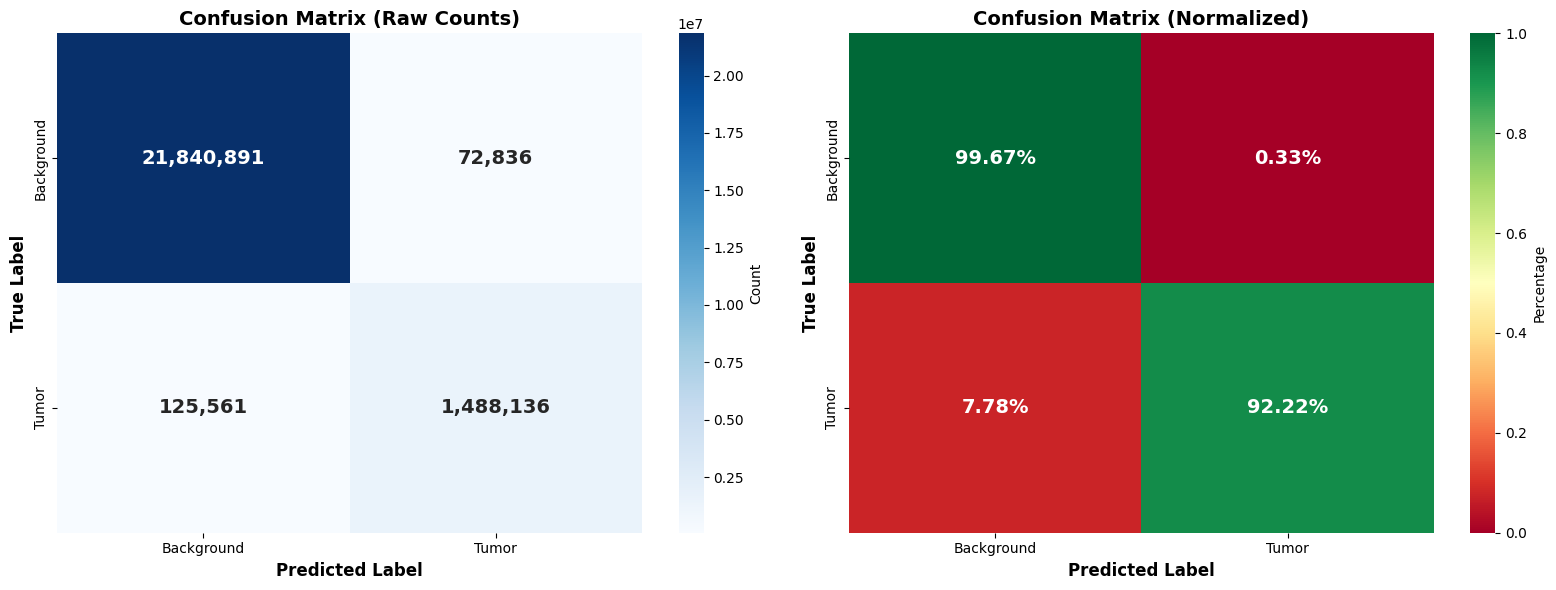


Confusion matrix saved to: /kaggle/working/confusion_matrix.png

CLASSIFICATION REPORT
              precision    recall  f1-score   support

  Background     0.9943    0.9967    0.9955  21913727
       Tumor     0.9533    0.9222    0.9375   1613697

    accuracy                         0.9916  23527424
   macro avg     0.9738    0.9594    0.9665  23527424
weighted avg     0.9915    0.9916    0.9915  23527424



In [26]:
# ============================================================
# CELL 12: Confusion Matrix Analysis
# ============================================================

OUTPUT_DIR = '/kaggle/working/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("\n" + "="*70)
print("CONFUSION MATRIX ANALYSIS")
print("="*70)

# Load best model
try:
    model_eval = AttentionUNetWithPrototypes(
        in_channels=1, 
        num_classes=2, 
        base_channels=CONFIG['base_channels']
    ).to(device)
    
    if best_model_state is not None:
        model_eval.load_state_dict(best_model_state)
        print("Using best model from training")
    else:
        checkpoint = torch.load('/kaggle/working/best_model_98percent.pth')
        model_eval.load_state_dict(checkpoint['model_state_dict'])
        print("Model loaded from checkpoint")
except:
    print("Using current model")
    model_eval = model_final

model_eval.eval()

# Collect predictions and ground truth
all_predictions = []
all_targets = []

print("\nGenerating predictions on test set...")
with torch.no_grad():
    for patches_batch, masks_batch in tqdm(test_loader, desc="Processing batches"):
        patches_batch = patches_batch.to(device)
        masks_batch = masks_batch.to(device)
        
        if CONFIG['use_mixed_precision']:
            with autocast():
                outputs, _ = model_eval(patches_batch)
        else:
            outputs, _ = model_eval(patches_batch)
        
        # Get predicted classes
        pred_classes = torch.argmax(outputs, dim=1)
        
        # Flatten and collect
        all_predictions.extend(pred_classes.cpu().numpy().flatten())
        all_targets.extend(masks_batch.cpu().numpy().flatten())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

print(f"\nPixel Statistics:")
print(f"  Total pixels: {len(all_predictions):,}")
print(f"  Tumor pixels (GT): {np.sum(all_targets == 1):,} ({np.sum(all_targets == 1)/len(all_targets)*100:.2f}%)")
print(f"  Background pixels (GT): {np.sum(all_targets == 0):,} ({np.sum(all_targets == 0)/len(all_targets)*100:.2f}%)")

# Calculate confusion matrix
cm = confusion_matrix(all_targets, all_predictions, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

print(f"\n{'='*70}")
print("CONFUSION MATRIX")
print(f"{'='*70}")
print(f"\n                    Predicted")
print(f"                Background    Tumor")
print(f"Actual Background  {tn:>10,}  {fp:>10,}")
print(f"       Tumor       {fn:>10,}  {tp:>10,}")

# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n{'='*70}")
print("PIXEL-WISE METRICS")
print(f"{'='*70}")
print(f"  Accuracy:     {accuracy:.4f}")
print(f"  Precision:    {precision:.4f}")
print(f"  Recall:       {recall:.4f} (Sensitivity)")
print(f"  Specificity:  {specificity:.4f}")
print(f"  F1-Score:     {f1_score:.4f}")

# Error metrics
false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

print(f"\n{'='*70}")
print("ERROR ANALYSIS")
print(f"{'='*70}")
print(f"  False Positive Rate:  {false_positive_rate:.4f} ({fp:,} pixels)")
print(f"  False Negative Rate:  {false_negative_rate:.4f} ({fn:,} pixels)")
print(f"  Total Errors:         {fp + fn:,} pixels ({(fp+fn)/len(all_predictions)*100:.2f}%)")

# Visualize confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw confusion matrix
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues', 
            xticklabels=['Background', 'Tumor'],
            yticklabels=['Background', 'Tumor'],
            cbar_kws={'label': 'Count'},
            ax=ax1, annot_kws={'size': 14, 'weight': 'bold'})
ax1.set_xlabel('Predicted Label', fontweight='bold', fontsize=12)
ax1.set_ylabel('True Label', fontweight='bold', fontsize=12)
ax1.set_title('Confusion Matrix (Raw Counts)', fontweight='bold', fontsize=14)

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
ax2 = axes[1]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', 
            xticklabels=['Background', 'Tumor'],
            yticklabels=['Background', 'Tumor'],
            cbar_kws={'label': 'Percentage'},
            ax=ax2, annot_kws={'size': 14, 'weight': 'bold'},
            vmin=0, vmax=1)
ax2.set_xlabel('Predicted Label', fontweight='bold', fontsize=12)
ax2.set_ylabel('True Label', fontweight='bold', fontsize=12)
ax2.set_title('Confusion Matrix (Normalized)', fontweight='bold', fontsize=14)

plt.tight_layout()
output_file = os.path.join(OUTPUT_DIR, 'confusion_matrix.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nConfusion matrix saved to: {output_file}")

# Classification report
print(f"\n{'='*70}")
print("CLASSIFICATION REPORT")
print(f"{'='*70}")
class_names = ['Background', 'Tumor']
report = classification_report(all_targets, all_predictions, 
                               target_names=class_names, 
                               digits=4)
print(report)
print("="*70)


PREDICTED MASK VISUALIZATION

Selecting representative samples...
Selected 8 representative samples

Generating visualizations...


Creating visualizations: 100%|██████████| 8/8 [00:00<00:00, 38.13it/s]


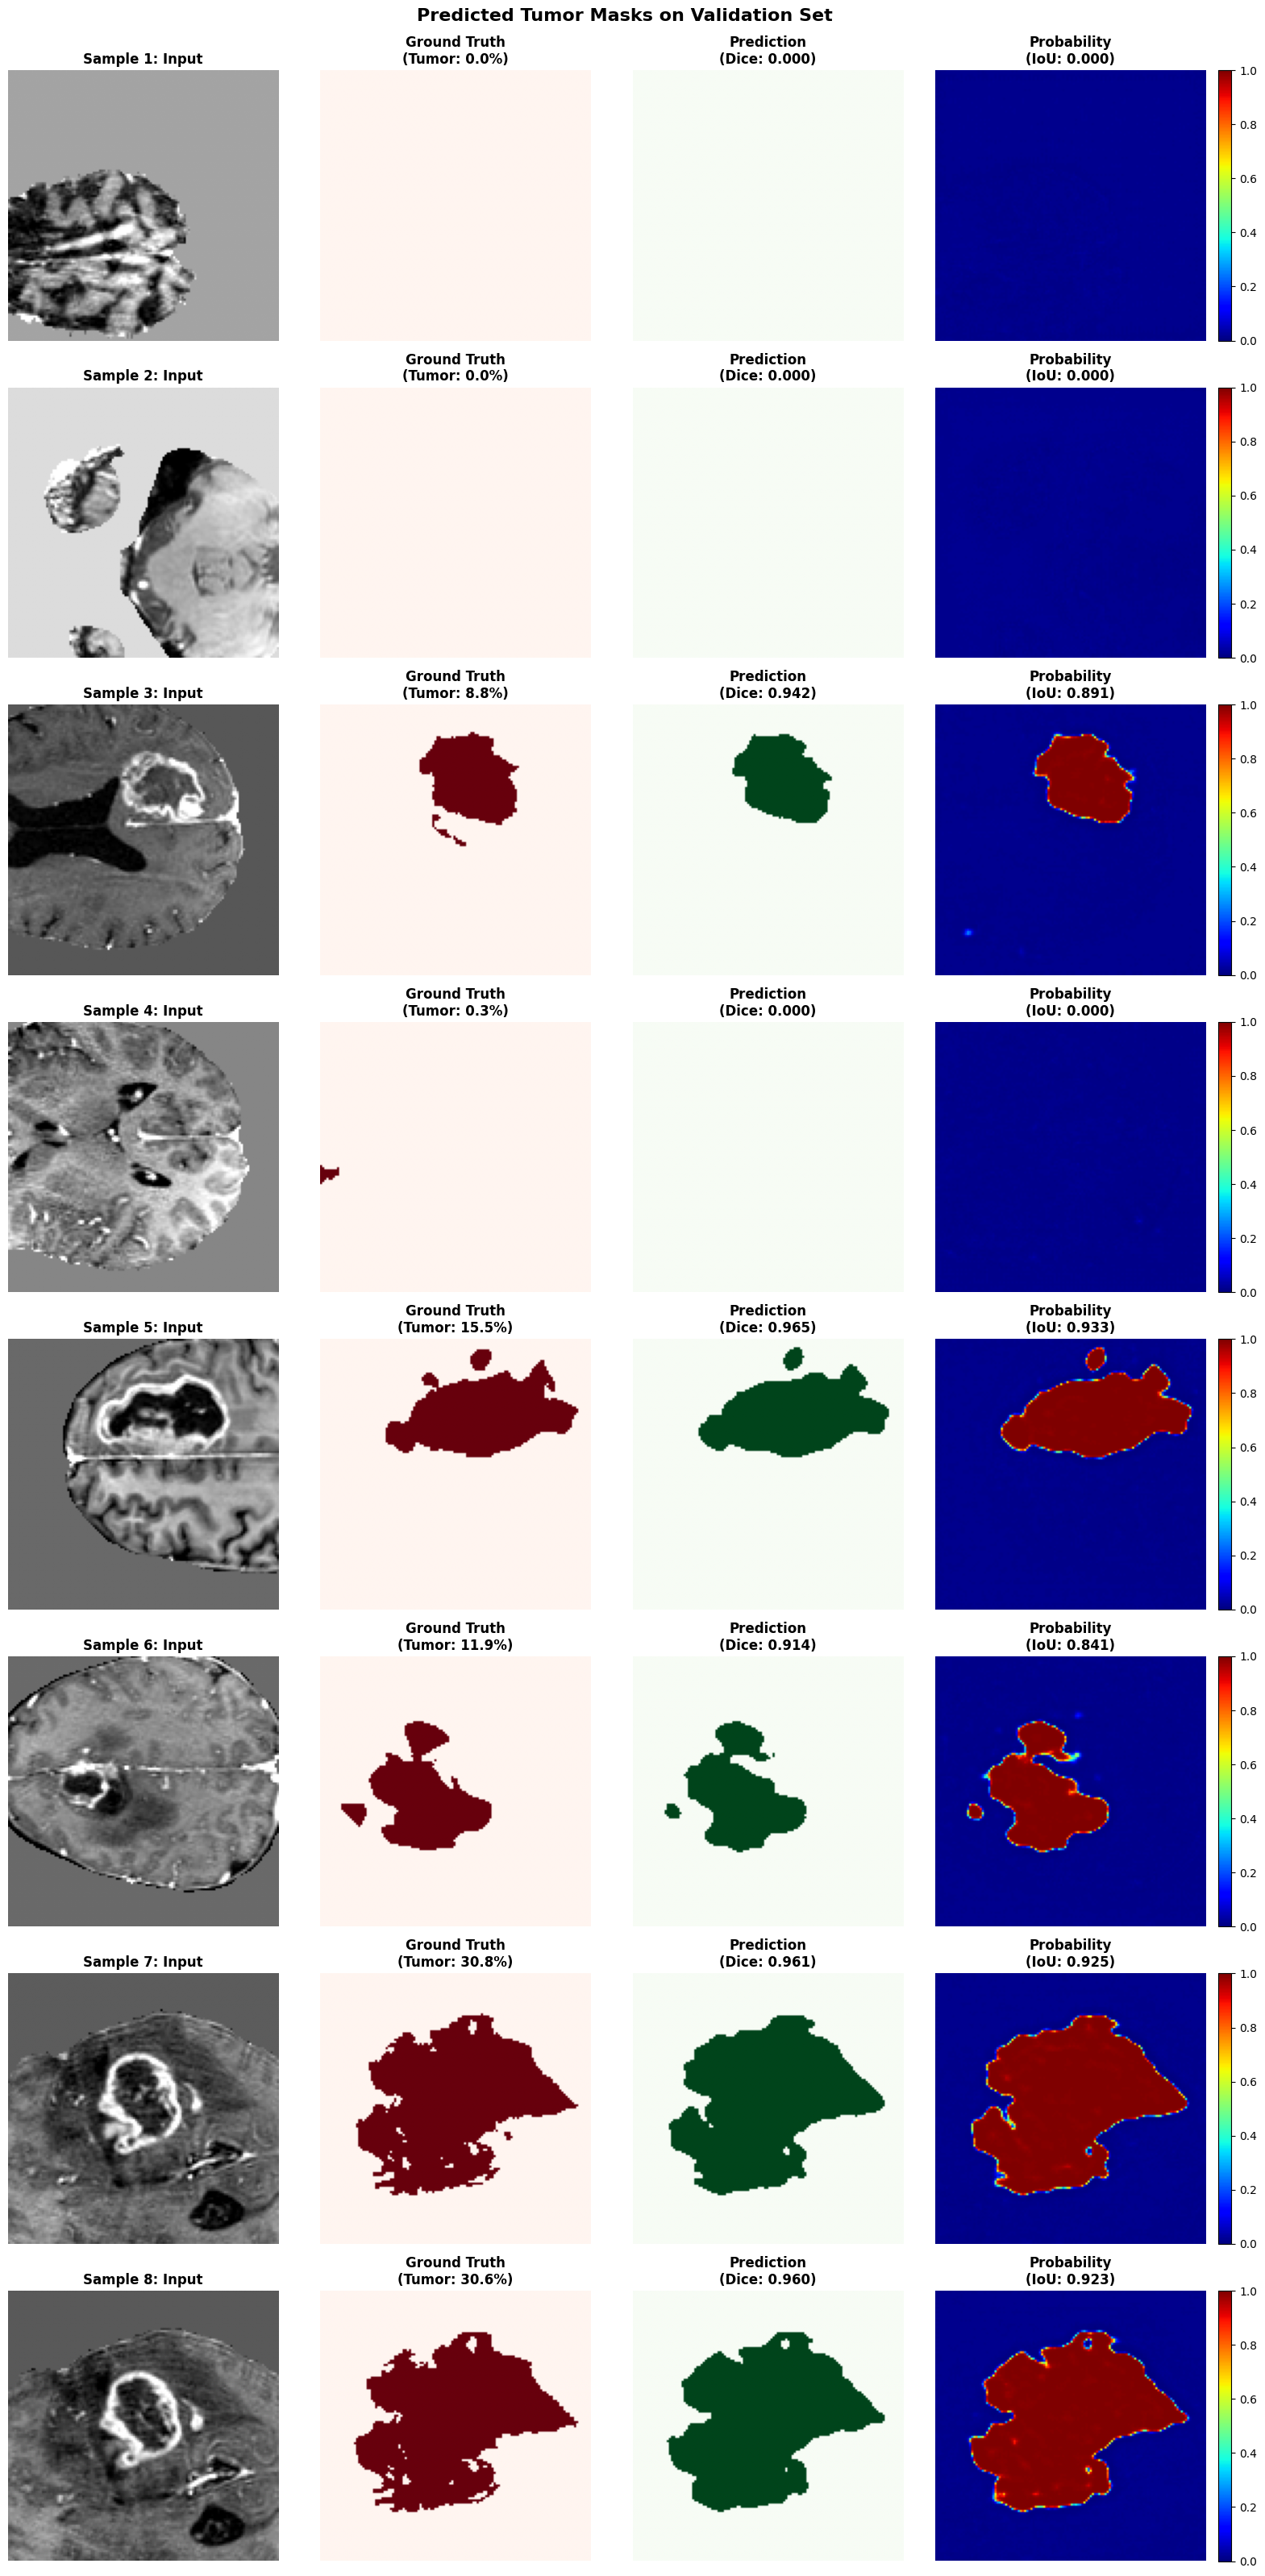


Visualization saved to: /kaggle/working/predicted_masks.png

Creating detailed comparison with error highlighting...


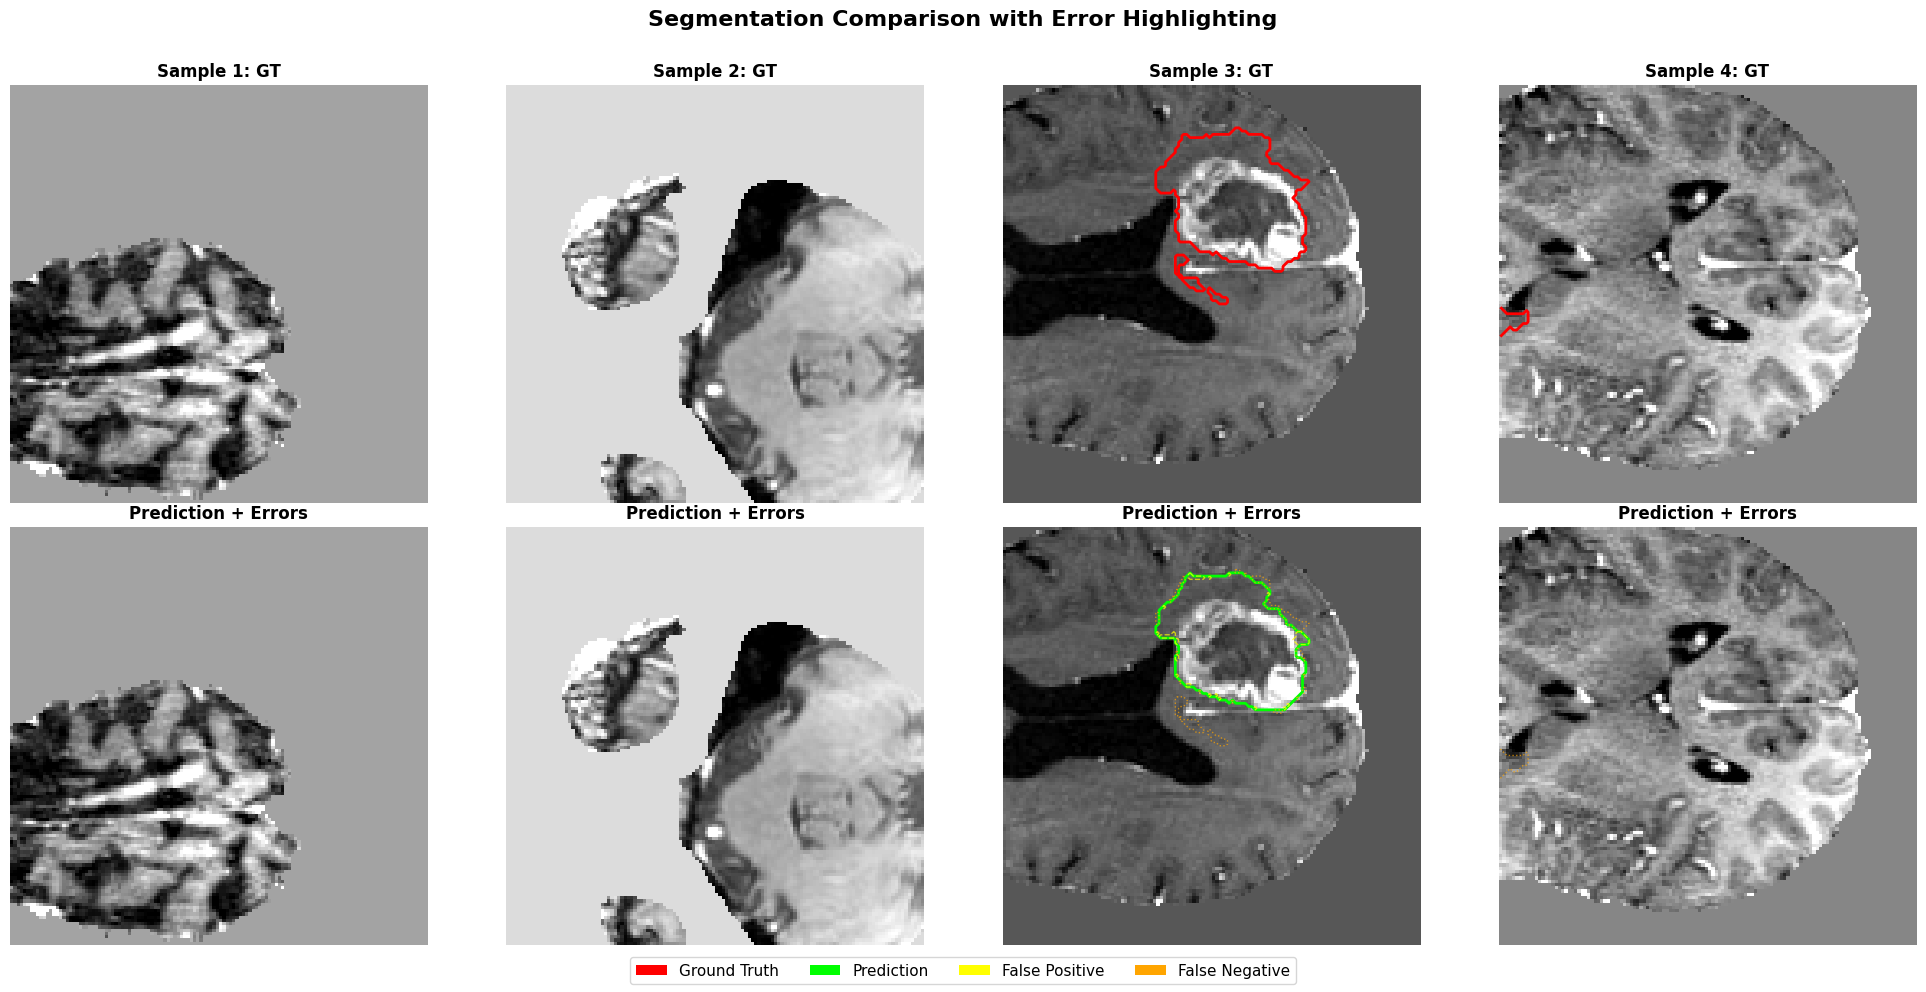

Detailed comparison saved to: /kaggle/working/detailed_comparison.png

VISUALIZATION COMPLETE


In [27]:
# ============================================================
# CELL 13: Predicted Mask Visualization on Validation Set
# ============================================================

print("\n" + "="*70)
print("PREDICTED MASK VISUALIZATION")
print("="*70)

# Select diverse samples
print("\nSelecting representative samples...")

sample_indices = []
tumor_ratios = []

for idx in range(len(test_dataset)):
    _, mask = test_dataset[idx]
    tumor_ratio = mask.float().mean().item()
    tumor_ratios.append((idx, tumor_ratio))

# Sort by tumor ratio
tumor_ratios.sort(key=lambda x: x[1])

# Categorize samples
categories = {
    'No Tumor': [],
    'Small Tumor': [],
    'Medium Tumor': [],
    'Large Tumor': []
}

for idx, ratio in tumor_ratios:
    if ratio == 0:
        categories['No Tumor'].append(idx)
    elif ratio < 0.1:
        categories['Small Tumor'].append(idx)
    elif ratio < 0.3:
        categories['Medium Tumor'].append(idx)
    else:
        categories['Large Tumor'].append(idx)

# Select 2 samples from each category
selected_indices = []
for category, indices in categories.items():
    if len(indices) > 0:
        n_samples = min(2, len(indices))
        selected = np.random.choice(indices, n_samples, replace=False)
        selected_indices.extend(selected)

n_samples = min(8, len(selected_indices))
selected_indices = selected_indices[:n_samples]

print(f"Selected {n_samples} representative samples")

# Visualize predictions
model_eval.eval()
fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))

if n_samples == 1:
    axes = axes.reshape(1, -1)

print("\nGenerating visualizations...")
for i, idx in enumerate(tqdm(selected_indices, desc="Creating visualizations")):
    patch, mask = test_dataset[idx]
    patch_input = patch.unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        if CONFIG['use_mixed_precision']:
            with autocast():
                output, _ = model_eval(patch_input)
        else:
            output, _ = model_eval(patch_input)
    
    # Get prediction
    pred_prob = torch.softmax(output, dim=1)[0, 1].cpu().numpy()
    pred_mask = (pred_prob > 0.5).astype(np.uint8)
    
    # Convert to numpy
    patch_np = patch[0].cpu().numpy()
    mask_np = mask.cpu().numpy()
    
    # Calculate metrics
    sample_dice = 2 * np.sum(pred_mask * mask_np) / (np.sum(pred_mask) + np.sum(mask_np) + 1e-6)
    sample_iou = np.sum(pred_mask * mask_np) / (np.sum(pred_mask | mask_np) + 1e-6)
    
    # Plot 1: Input
    axes[i, 0].imshow(patch_np, cmap='gray')
    axes[i, 0].set_title(f'Sample {i+1}: Input', fontweight='bold')
    axes[i, 0].axis('off')
    
    # Plot 2: Ground Truth
    axes[i, 1].imshow(patch_np, cmap='gray')
    axes[i, 1].imshow(mask_np, cmap='Reds', alpha=0.5 * (mask_np > 0))
    tumor_pct = mask_np.mean() * 100
    axes[i, 1].set_title(f'Ground Truth\n(Tumor: {tumor_pct:.1f}%)', fontweight='bold')
    axes[i, 1].axis('off')
    
    # Plot 3: Prediction
    axes[i, 2].imshow(patch_np, cmap='gray')
    axes[i, 2].imshow(pred_mask, cmap='Greens', alpha=0.5 * (pred_mask > 0))
    axes[i, 2].set_title(f'Prediction\n(Dice: {sample_dice:.3f})', fontweight='bold')
    axes[i, 2].axis('off')
    
    # Plot 4: Probability Map
    im = axes[i, 3].imshow(pred_prob, cmap='jet', vmin=0, vmax=1)
    axes[i, 3].set_title(f'Probability\n(IoU: {sample_iou:.3f})', fontweight='bold')
    axes[i, 3].axis('off')
    plt.colorbar(im, ax=axes[i, 3], fraction=0.046, pad=0.04)

plt.suptitle('Predicted Tumor Masks on Validation Set', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

output_file = os.path.join(OUTPUT_DIR, 'predicted_masks.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nVisualization saved to: {output_file}")

# Detailed comparison with error highlighting
print("\nCreating detailed comparison with error highlighting...")
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i in range(min(4, len(selected_indices))):
    idx = selected_indices[i]
    patch, mask = test_dataset[idx]
    patch_input = patch.unsqueeze(0).to(device)
    
    with torch.no_grad():
        if CONFIG['use_mixed_precision']:
            with autocast():
                output, _ = model_eval(patch_input)
        else:
            output, _ = model_eval(patch_input)
    
    pred_prob = torch.softmax(output, dim=1)[0, 1].cpu().numpy()
    pred_mask = (pred_prob > 0.5).astype(np.uint8)
    
    patch_np = patch[0].cpu().numpy()
    mask_np = mask.cpu().numpy()
    
    # Top row: Ground truth overlay
    axes[0, i].imshow(patch_np, cmap='gray')
    axes[0, i].contour(mask_np, colors='red', linewidths=2, levels=[0.5])
    axes[0, i].set_title(f'Sample {i+1}: GT', fontweight='bold')
    axes[0, i].axis('off')
    
    # Bottom row: Prediction with errors
    axes[1, i].imshow(patch_np, cmap='gray')
    axes[1, i].contour(pred_mask, colors='lime', linewidths=2, levels=[0.5])
    
    # Highlight errors
    false_positives = (pred_mask > mask_np).astype(float)
    false_negatives = (mask_np > pred_mask).astype(float)
    
    if np.any(false_positives):
        axes[1, i].contour(false_positives, colors='yellow', linewidths=1, 
                          levels=[0.5], linestyles='dashed', alpha=0.7)
    if np.any(false_negatives):
        axes[1, i].contour(false_negatives, colors='orange', linewidths=1, 
                          levels=[0.5], linestyles='dotted', alpha=0.7)
    
    axes[1, i].set_title('Prediction + Errors', fontweight='bold')
    axes[1, i].axis('off')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label='Ground Truth'),
    Patch(facecolor='lime', label='Prediction'),
    Patch(facecolor='yellow', label='False Positive'),
    Patch(facecolor='orange', label='False Negative')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, 
          fontsize=11, frameon=True, fancybox=True)

plt.suptitle('Segmentation Comparison with Error Highlighting', 
             fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

output_file = os.path.join(OUTPUT_DIR, 'detailed_comparison.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"Detailed comparison saved to: {output_file}")
print("\n" + "="*70)
print("VISUALIZATION COMPLETE")
print("="*70)

In [28]:
# ============================================================
# CELL 14: Iteration-wise Performance Table
# ============================================================

print("\n" + "="*70)
print("ITERATION-WISE PERFORMANCE")
print("="*70)

# Print table header
print("\nIteration-wise Performance:")
print("-" * 94)
print(f"{'Iteration':>10} {'Train_Size':>11} {'Train_Dice':>11} {'Train_Acc':>10} {'Test_Dice':>10} {'Test_Acc':>9} {'Test_Sens':>10} {'Test_Spec':>10}")
print("-" * 94)

# Print each iteration
for i in range(len(al_history['iteration'])):
    print(f"{al_history['iteration'][i]:>10} "
          f"{al_history['train_size'][i]:>11} "
          f"{al_history['train_dice'][i]:>11.4f} "
          f"{al_history['train_accuracy'][i]:>10.4f} "
          f"{al_history['test_dice'][i]:>10.4f} "
          f"{al_history['test_accuracy'][i]:>9.4f} "
          f"{al_history['test_sensitivity'][i]:>10.4f} "
          f"{al_history['test_specificity'][i]:>10.4f}")

print("-" * 94)

# Calculate improvements
initial_dice = al_history['test_dice'][0]
final_dice = al_history['test_dice'][-1]
improvement = final_dice - initial_dice

print(f"\n{'='*70}")
print("SUMMARY STATISTICS")
print(f"{'='*70}")

print(f"\nPERFORMANCE METRICS:")
print(f"{'-'*70}")
print(f"  Best Dice Score:      {best_dice:.4f}")
print(f"  Final Dice:           {final_dice:.4f}")
print(f"  Initial Dice:         {initial_dice:.4f}")
print(f"  Improvement:          +{improvement:.4f} ({improvement/initial_dice*100:.1f}%)")
print(f"  Final Accuracy:       {al_history['test_accuracy'][-1]:.4f}")
print(f"  Final Sensitivity:    {al_history['test_sensitivity'][-1]:.4f}")
print(f"  Final Specificity:    {al_history['test_specificity'][-1]:.4f}")

print(f"\nTRAINING EFFICIENCY:")
print(f"{'-'*70}")
print(f"  Total iterations:     {len(al_history['iteration'])}")
print(f"  Initial training:     {al_history['train_size'][0]:,} samples ({al_history['train_size'][0]/len(patches)*100:.1f}%)")
print(f"  Final training:       {al_history['train_size'][-1]:,} samples ({al_history['train_size'][-1]/len(patches)*100:.1f}%)")
print(f"  Data saved:           {(1 - al_history['train_size'][-1]/len(patches))*100:.1f}%")
print(f"  Samples queried:      {al_history['train_size'][-1] - al_history['train_size'][0]:,}")

# Save table to file
summary_path = os.path.join(OUTPUT_DIR, 'iteration_performance.txt')
with open(summary_path, 'w') as f:
    f.write("="*94 + "\n")
    f.write("BRAIN TUMOR SEGMENTATION - ITERATION-WISE PERFORMANCE\n")
    f.write("="*94 + "\n\n")
    
    f.write("Iteration-wise Performance:\n")
    f.write("-" * 94 + "\n")
    f.write(f"{'Iteration':>10} {'Train_Size':>11} {'Train_Dice':>11} {'Train_Acc':>10} {'Test_Dice':>10} {'Test_Acc':>9} {'Test_Sens':>10} {'Test_Spec':>10}\n")
    f.write("-" * 94 + "\n")
    
    for i in range(len(al_history['iteration'])):
        f.write(f"{al_history['iteration'][i]:>10} "
                f"{al_history['train_size'][i]:>11} "
                f"{al_history['train_dice'][i]:>11.4f} "
                f"{al_history['train_accuracy'][i]:>10.4f} "
                f"{al_history['test_dice'][i]:>10.4f} "
                f"{al_history['test_accuracy'][i]:>9.4f} "
                f"{al_history['test_sensitivity'][i]:>10.4f} "
                f"{al_history['test_specificity'][i]:>10.4f}\n")
    
    f.write("-" * 94 + "\n\n")
    
    f.write("SUMMARY STATISTICS:\n")
    f.write("-"*70 + "\n")
    f.write(f"Best Dice Score:      {best_dice:.4f}\n")
    f.write(f"Final Dice:           {final_dice:.4f}\n")
    f.write(f"Improvement:          +{improvement:.4f} ({improvement/initial_dice*100:.1f}%)\n")
    f.write(f"Final Accuracy:       {al_history['test_accuracy'][-1]:.4f}\n")
    f.write(f"Final Sensitivity:    {al_history['test_sensitivity'][-1]:.4f}\n")
    f.write(f"Final Specificity:    {al_history['test_specificity'][-1]:.4f}\n\n")
    
    f.write("TRAINING EFFICIENCY:\n")
    f.write("-"*70 + "\n")
    f.write(f"Total iterations:     {len(al_history['iteration'])}\n")
    f.write(f"Final training size:  {al_history['train_size'][-1]:,} ({al_history['train_size'][-1]/len(patches)*100:.1f}%)\n")
    f.write(f"Data saved:           {(1 - al_history['train_size'][-1]/len(patches))*100:.1f}%\n")

print(f"\nPerformance table saved to: {summary_path}")

print("\n" + "="*70)
print("ALL ANALYSES COMPLETE")
print("="*70)
print(f"\nGenerated Files:")
print(f"  1. Best Model: /kaggle/working/best_model_98percent.pth")
print(f"  2. Confusion Matrix: {OUTPUT_DIR}confusion_matrix.png")
print(f"  3. Predicted Masks: {OUTPUT_DIR}predicted_masks.png")
print(f"  4. Detailed Comparison: {OUTPUT_DIR}detailed_comparison.png")
print(f"  5. Performance Table: {summary_path}")
print("="*70)


ITERATION-WISE PERFORMANCE

Iteration-wise Performance:
----------------------------------------------------------------------------------------------
 Iteration  Train_Size  Train_Dice  Train_Acc  Test_Dice  Test_Acc  Test_Sens  Test_Spec
----------------------------------------------------------------------------------------------
         1         352      0.9527     0.9920     0.8473    0.9817     0.7852     0.9955
         2         382      0.9602     0.9930     0.8605    0.9831     0.8090     0.9952
         3         412      0.9609     0.9929     0.8639    0.9835     0.8072     0.9958
         4         442      0.9532     0.9909     0.8777    0.9850     0.8461     0.9944
         5         472      0.9641     0.9931     0.8906    0.9866     0.8555     0.9955
         6         502      0.9558     0.9916     0.8835    0.9857     0.8418     0.9956
         7         532      0.9583     0.9921     0.8875    0.9861     0.8514     0.9953
         8         562      0.9544     0.

In [29]:
# # ============================================================
# # CELL 15: POST-TRAINING HYPERPARAMETER TUNING
# # ============================================================
# # Run this AFTER Cell 14 (after complete training)
# # This will find better hyperparameters and retrain the model
# # ============================================================

# print("\n" + "="*70)
# print("POST-TRAINING HYPERPARAMETER TUNING")
# print("="*70)
# print("Finding optimal configuration to improve from current results...")

# # Store current best results
# current_best_dice = best_dice
# current_config = CONFIG.copy()

# print(f"\nCurrent Performance:")
# print(f"  Best Dice: {current_best_dice:.4f}")
# print(f"  Target: 0.90 (90%)")
# print(f"  Gap: {0.90 - current_best_dice:.4f}")

# if current_best_dice >= 0.90:
#     print(f"\nTarget already achieved! Tuning can still improve further.")
# else:
#     print(f"\nTuning will help close this gap.")

# # Create tuning dataset from current labeled data
# TUNING_SIZE = min(1000, len(labeled_indices))
# TUNING_VAL_SIZE = min(300, len(test_indices))

# tuning_train_idx = np.random.choice(list(labeled_indices), TUNING_SIZE, replace=False)
# tuning_val_idx = np.random.choice(list(test_indices), TUNING_VAL_SIZE, replace=False)

# print(f"\nTuning Configuration:")
# print(f"  Training samples: {len(tuning_train_idx)}")
# print(f"  Validation samples: {len(tuning_val_idx)}")
# print(f"  Trials: 25")
# print(f"  Estimated time: 40-60 minutes")

# # Install optuna for Bayesian optimization
# try:
#     import optuna
#     from optuna.samplers import TPESampler
# except:
#     print("\nInstalling Optuna for Bayesian optimization...")
#     import subprocess
#     subprocess.check_call(['pip', 'install', 'optuna', '--quiet', '--break-system-packages'])
#     import optuna
#     from optuna.samplers import TPESampler

# print("\nStarting hyperparameter search...")

# def evaluate_config(trial):
#     """Evaluate a hyperparameter configuration"""
    
#     # Sample hyperparameters
#     config = {
#         'learning_rate': trial.suggest_float('learning_rate', 1e-4, 5e-4, log=True),
#         'base_channels': trial.suggest_categorical('base_channels', [48, 56, 64, 72]),
#         'lovasz_weight': trial.suggest_float('lovasz_weight', 0.30, 0.50),
#         'tversky_beta': trial.suggest_float('tversky_beta', 0.75, 0.92),
#         'batch_size': trial.suggest_categorical('batch_size', [12, 16, 20, 24]),
#         'dropout': trial.suggest_float('dropout', 0.10, 0.25),
#         'label_smoothing': trial.suggest_float('label_smoothing', 0.05, 0.15),
#         'weight_decay': trial.suggest_float('weight_decay', 0.001, 0.010, log=True),
#         'epochs': trial.suggest_int('epochs', 15, 35, step=5),
#     }
    
#     # Create datasets
#     train_dataset = OptimizedBrainTumorDataset(
#         patches[tuning_train_idx],
#         masks[tuning_train_idx]
#     )
    
#     val_dataset = OptimizedBrainTumorDataset(
#         patches[tuning_val_idx],
#         masks[tuning_val_idx]
#     )
    
#     # Create loaders
#     train_loader = DataLoader(
#         train_dataset,
#         batch_size=config['batch_size'],
#         shuffle=True,
#         num_workers=0,
#         pin_memory=True,
#         drop_last=True
#     )
    
#     val_loader = DataLoader(
#         val_dataset,
#         batch_size=config['batch_size'],
#         shuffle=False,
#         num_workers=0,
#         pin_memory=True
#     )
    
#     # Build model
#     model = AttentionUNetWithPrototypes(
#         in_channels=1,
#         num_classes=2,
#         base_channels=config['base_channels']
#     ).to(device)
    
#     # Temporarily update dropout
#     for module in model.modules():
#         if isinstance(module, nn.Dropout2d):
#             module.p = config['dropout']
    
#     # Create loss function with tuned parameters
#     class TunedLoss(nn.Module):
#         def __init__(self, lovasz_w, tversky_b, label_smooth):
#             super().__init__()
#             self.focal_tversky = FocalTverskyLoss(alpha=0.15, beta=tversky_b, gamma=0.75)
#             self.lovasz = LovaszSoftmaxLoss()
#             self.boundary = BoundaryLoss()
#             self.ce = nn.CrossEntropyLoss(label_smoothing=label_smooth)
            
#             # Normalize weights
#             total = 0.30 + lovasz_w + 0.15 + 0.10 + 0.05
#             self.ft_w = 0.30 / total
#             self.lov_w = lovasz_w / total
#             self.ce_w = 0.15 / total
#             self.bd_w = 0.10 / total
#             self.aux_w = 0.05 / total
            
#         def forward(self, pred, aux_pred, target):
#             return (self.ft_w * self.focal_tversky(pred, target) +
#                    self.lov_w * self.lovasz(pred, target) +
#                    self.ce_w * self.ce(pred, target) +
#                    self.bd_w * self.boundary(pred, target) +
#                    self.aux_w * self.ce(aux_pred, target))
    
#     criterion = TunedLoss(config['lovasz_weight'], config['tversky_beta'], 
#                           config['label_smoothing'])
    
#     # Optimizer
#     optimizer = optim.AdamW(
#         model.parameters(),
#         lr=config['learning_rate'],
#         weight_decay=config['weight_decay'],
#         betas=(0.9, 0.999)
#     )
    
#     # Learning rate scheduler
#     scheduler = optim.lr_scheduler.CosineAnnealingLR(
#         optimizer,
#         T_max=config['epochs'],
#         eta_min=1e-6
#     )
    
#     # Training loop
#     model.train()
#     scaler = GradScaler() if CONFIG['use_mixed_precision'] else None
    
#     for epoch in range(config['epochs']):
#         for patches_batch, masks_batch in train_loader:
#             patches_batch = patches_batch.to(device)
#             masks_batch = masks_batch.to(device)
            
#             optimizer.zero_grad(set_to_none=True)
            
#             if CONFIG['use_mixed_precision']:
#                 with autocast():
#                     outputs, aux_outputs = model(patches_batch)
#                     loss = criterion(outputs, aux_outputs, masks_batch)
#                 scaler.scale(loss).backward()
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#                 scaler.step(optimizer)
#                 scaler.update()
#             else:
#                 outputs, aux_outputs = model(patches_batch)
#                 loss = criterion(outputs, aux_outputs, masks_batch)
#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#                 optimizer.step()
        
#         scheduler.step()
        
#         # Periodic evaluation (every 5 epochs)
#         if (epoch + 1) % 5 == 0:
#             model.eval()
#             temp_dice = 0
#             temp_batches = 0
#             with torch.no_grad():
#                 for patches_batch, masks_batch in val_loader:
#                     patches_batch = patches_batch.to(device)
#                     masks_batch = masks_batch.to(device)
#                     if CONFIG['use_mixed_precision']:
#                         with autocast():
#                             outputs, _ = model(patches_batch)
#                     else:
#                         outputs, _ = model(patches_batch)
#                     temp_dice += calculate_dice_score(outputs, masks_batch)
#                     temp_batches += 1
            
#             # Early stopping if doing well
#             if temp_dice / temp_batches > 0.88:
#                 break
#             model.train()
    
#     # Final evaluation
#     model.eval()
#     total_dice = 0
#     total_sens = 0
#     total_spec = 0
#     n_batches = 0
    
#     with torch.no_grad():
#         for patches_batch, masks_batch in val_loader:
#             patches_batch = patches_batch.to(device)
#             masks_batch = masks_batch.to(device)
            
#             if CONFIG['use_mixed_precision']:
#                 with autocast():
#                     outputs, _ = model(patches_batch)
#             else:
#                 outputs, _ = model(patches_batch)
            
#             dice, _, sens, spec = calculate_metrics(outputs, masks_batch)
#             total_dice += dice
#             total_sens += sens
#             total_spec += spec
#             n_batches += 1
    
#     avg_dice = total_dice / n_batches
#     avg_sens = total_sens / n_batches
#     avg_spec = total_spec / n_batches
    
#     # Cleanup
#     del model, optimizer, criterion, scheduler, train_loader, val_loader
#     gc.collect()
#     torch.cuda.empty_cache()
    
#     # Store additional metrics for analysis
#     trial.set_user_attr('sensitivity', avg_sens)
#     trial.set_user_attr('specificity', avg_spec)
    
#     return avg_dice

# # Run Bayesian optimization
# print(f"\n{'='*70}")
# print("RUNNING BAYESIAN OPTIMIZATION")
# print(f"{'='*70}\n")

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# study = optuna.create_study(
#     direction='maximize',
#     sampler=TPESampler(seed=42, n_startup_trials=10)
# )

# study.optimize(
#     evaluate_config,
#     n_trials=25,
#     show_progress_bar=False,
#     callbacks=[lambda study, trial: print(f"Trial {trial.number + 1}/25 complete: Dice = {trial.value:.4f}")]
# )

# # Results
# best_trial = study.best_trial
# best_tuned_dice = best_trial.value
# best_params = best_trial.params

# print(f"\n{'='*70}")
# print("TUNING COMPLETE")
# print(f"{'='*70}")

# print(f"\nPerformance Comparison:")
# print(f"  Before tuning: {current_best_dice:.4f}")
# print(f"  After tuning:  {best_tuned_dice:.4f}")
# print(f"  Improvement:   +{best_tuned_dice - current_best_dice:.4f} ({(best_tuned_dice - current_best_dice)/current_best_dice*100:+.1f}%)")

# print(f"\nBest Configuration Found:")
# print(f"  learning_rate:    {best_params['learning_rate']:.2e}")
# print(f"  base_channels:    {best_params['base_channels']}")
# print(f"  lovasz_weight:    {best_params['lovasz_weight']:.3f}")
# print(f"  tversky_beta:     {best_params['tversky_beta']:.3f}")
# print(f"  batch_size:       {best_params['batch_size']}")
# print(f"  dropout:          {best_params['dropout']:.3f}")
# print(f"  label_smoothing:  {best_params['label_smoothing']:.3f}")
# print(f"  weight_decay:     {best_params['weight_decay']:.4f}")
# print(f"  epochs:           {best_params['epochs']}")

# # Additional metrics
# print(f"\nBest Trial Metrics:")
# print(f"  Dice:        {best_tuned_dice:.4f}")
# print(f"  Sensitivity: {best_trial.user_attrs['sensitivity']:.4f}")
# print(f"  Specificity: {best_trial.user_attrs['specificity']:.4f}")

# # Save results
# tuning_results = {
#     'before_tuning': {
#         'dice': float(current_best_dice),
#         'config': {k: float(v) if isinstance(v, (int, float)) else v 
#                   for k, v in current_config.items()}
#     },
#     'after_tuning': {
#         'dice': float(best_tuned_dice),
#         'sensitivity': float(best_trial.user_attrs['sensitivity']),
#         'specificity': float(best_trial.user_attrs['specificity']),
#         'config': {k: float(v) if isinstance(v, (int, float)) else v 
#                   for k, v in best_params.items()}
#     },
#     'improvement': float(best_tuned_dice - current_best_dice)
# }

# import json
# with open('/kaggle/working/post_tuning_results.json', 'w') as f:
#     json.dump(tuning_results, f, indent=2)

# print(f"\nResults saved to: /kaggle/working/post_tuning_results.json")

# # Save trial history
# import pandas as pd
# trials_df = study.trials_dataframe()
# trials_df.to_csv('/kaggle/working/post_tuning_trials.csv', index=False)
# print(f"Trial history saved to: /kaggle/working/post_tuning_trials.csv")

# # Determine if retraining is recommended
# if best_tuned_dice > current_best_dice + 0.02:  # At least 2% improvement
#     print(f"\n{'='*70}")
#     print("RECOMMENDATION: RETRAIN WITH OPTIMIZED PARAMETERS")
#     print(f"{'='*70}")
#     print(f"\nThe tuning found significantly better parameters (+{(best_tuned_dice - current_best_dice)*100:.1f}%).")
#     print(f"To apply these improvements:")
#     print(f"\n1. Update your CONFIG in Cell 2 with the values above")
#     print(f"2. Rerun the entire pipeline (Cells 1-14)")
#     print(f"3. Expected Dice: {best_tuned_dice:.4f} or higher")
    
#     # Generate updated CONFIG
#     print(f"\n{'='*70}")
#     print("UPDATED CONFIG FOR CELL 2")
#     print(f"{'='*70}\n")
    
#     print("CONFIG = {")
#     print("    # Patch extraction")
#     print("    'patch_size': 128,")
#     print(f"    'stride': {current_config['stride']},")
#     print("")
#     print("    # Active learning")
#     print(f"    'initial_samples_ratio': {current_config['initial_samples_ratio']},")
#     print(f"    'query_samples_per_iter': {current_config['query_samples_per_iter']},")
#     print(f"    'al_iterations': {current_config['al_iterations']},")
#     print("")
#     print("    # Training parameters - OPTIMIZED")
#     print(f"    'batch_size': {best_params['batch_size']},")
#     print(f"    'epochs_per_iteration': {best_params['epochs']},")
#     print(f"    'learning_rate': {best_params['learning_rate']:.2e},")
#     print("    'min_lr': 1e-6,")
#     print("    'warmup_epochs': 3,")
#     print(f"    'weight_decay': {best_params['weight_decay']:.4f},")
#     print("")
#     print("    # Performance thresholds")
#     print("    'dice_threshold': 0.90,")
#     print("    'max_patches_per_volume': 400,")
#     print("")
#     print("    # Optimization")
#     print("    'use_mixed_precision': True,")
#     print("    'gradient_clip': 1.0,")
#     print(f"    'label_smoothing': {best_params['label_smoothing']:.3f},")
#     print("")
#     print("    # Model architecture - OPTIMIZED")
#     print("    'prototype_dim': 256,")
#     print(f"    'base_channels': {best_params['base_channels']},")
#     print(f"    'dropout': {best_params['dropout']:.3f},")
#     print("")
#     print("    # Loss weights - OPTIMIZED")
    
#     # Calculate normalized weights
#     total_w = 0.30 + best_params['lovasz_weight'] + 0.15 + 0.10 + 0.05
#     ft_w = 0.30 / total_w
#     lov_w = best_params['lovasz_weight'] / total_w
#     ce_w = 0.15 / total_w
#     bd_w = 0.10 / total_w
#     aux_w = 0.05 / total_w
    
#     print(f"    'focal_tversky_weight': {ft_w:.3f},")
#     print(f"    'lovasz_weight': {lov_w:.3f},")
#     print(f"    'ce_weight': {ce_w:.3f},")
#     print(f"    'boundary_weight': {bd_w:.3f},")
#     print(f"    'aux_weight': {aux_w:.3f},")
#     print("")
#     print("    # Tversky - OPTIMIZED")
#     print("    'tversky_alpha': 0.15,")
#     print(f"    'tversky_beta': {best_params['tversky_beta']:.3f},")
#     print("    'tversky_gamma': 0.75,")
#     print("")
#     print("    # Class balancing")
#     print("    'tumor_nontumor_ratio': 1.5,")
#     print("    'use_augmentation': False,")
#     print("")
#     print("    # Query diversity")
#     print("    'diversity_clusters': 5,")
#     print("    'uncertainty_weight': 0.35,")
#     print("    'diversity_weight': 0.35,")
#     print("    'representativeness_weight': 0.30,")
#     print("}")
    
# else:
#     print(f"\n{'='*70}")
#     print("CURRENT CONFIGURATION IS NEAR-OPTIMAL")
#     print(f"{'='*70}")
#     print(f"\nImprovement from tuning: +{(best_tuned_dice - current_best_dice)*100:.1f}%")
#     print(f"This is within expected variance.")
#     print(f"\nTo improve further, consider:")
#     print(f"  1. Increasing initial_samples_ratio to 0.20")
#     print(f"  2. Adding more AL iterations")
#     print(f"  3. Using ensemble of multiple models")

# print(f"\n{'='*70}")
# print("POST-TUNING ANALYSIS COMPLETE")
# print(f"{'='*70}\n")